## **Classification of Open and Close Drawer Actions Using Statistical Learning Methods**

### Introduction

The main objective of this project is to develop a robust algorithm to classify two robotic manipulation actions—**opening and closing a drawer**—based on episode-level data.

Through feature engineering, we extract numerical features primarily from two key sources: `observation.state` and `action` variables. These features capture temporal patterns and statistical characteristics within each episode. To improve model interpretability and reduce redundancy, we also apply correlation filtering and statistical aggregation.

A total of **five classification models** are trained and evaluated:

- Logistic Regression
- Lasso-regularized Logistic Regression 
- Random Forest  
- Gradient Boosting 
- Support Vector Machine (Linear SVM)

Each model is fitted using the selected features, and their predictive performance is evaluated on a held-out test set using metrics such as accuracy, precision, F1 score, and AUC-ROC.

The results are visualized and compared, with additional analysis of feature importance to interpret the most influential variables contributing to model decisions.



### Data Description

The dataset used in this study is derived from the PhysicalAI Robotics Manipulation in the Kitchen benchmark. Specifically, we extracted the **open drawer and close drawer** episodes from the dataset. Each episode consists of multiple components, including `data/`, `meta/`, and `video/` folders. In this study, we focused only on the `data/`folder, which contains the raw all action and observation state variables required for further analysis. These were organized into a structured DataFrame format for downstream processing.


- **Data Source:** 

  [NVIDIA/PhysicalAI-Robotics-Manipulation-Kitchen Dataset (Hugging Face)](https://huggingface.co/datasets/nvidia/PhysicalAI-Robotics-Manipulation-Kitchen)

- **Data Preprocessing:**  

  *   Download folders open_drawer and close_drawer from [NVIDIA/PhysicalAI-Robotics-Manipulation-Kitchen Dataset (Hugging Face)](https://huggingface.co/datasets/nvidia/PhysicalAI-Robotics-Manipulation-Kitchen)

  *   Convert all `data/chunk-000/episode_xxxxxx.parquet` to episode_xxxx.csv files;
  *   Merge all episode_xxxxxx.csv files from both `open_drawer` and `close_drawer` folders into one csv file and add `label_index` colunm: open_drawer=0, open_drawer=1;
  *   Upload to Hugging face: [merged_open_close_drawer.csv](https://huggingface.co/datasets/caiyan123/open-close-drawer-csv/resolve/main/merged_open_close_drawer.csv)
  *  Expand vector variables `action` and `observation.state` into separate colums like action_0, action_1.....action_33 and obs_state_0, obs_state_1,...obs_state_12;
  *  Save as new dataframe **df_final**.

- **Main Variable Definition:**

| action_index  | name                               | summary                      |
|--------------|------------------------------------|------------------------------|
| action_0     | front_rocker                       | base / wheels                |
| action_1~2    | front left or right wheel                  | base / wheels                |
| action_3~4    | rearleft or right wheel                    | base / wheels                |
| action_5     | ewellix_torso_joint                | Vertical lift for torso height                   |
| action_6     | pan_joint                          | camera or sensor pan                   |
| action_7     | tilt_joint                         | camera or sensor tilt                  |
| action_8~14     | left_arm_joint_1~7                   | left arm main joints         |
| action_15~20   | left arm inner or outer finger or knuckle joints     | left arm finger or knuckle joints      |
| action_21~27   | right_arm_joint_1~7                 | right arm main joints        |
| action_28~33   | right arm inner or outer finger or knuckle joints            | right arm finger or knuckle joints                   |


| obs_state_index | name             | summary                                                                 |
|-----------------|------------------|-------------------------------------------------------------------------|
| obs_state_0     | r_xx             | X-axis projection of drawer orientation (rotation matrix component)    |
| obs_state_1     | r_xy             | X-axis projection of drawer orientation (rotation matrix component)    |
| obs_state_2     | r_xz             | X-axis projection of drawer orientation (rotation matrix component)    |
| obs_state_3     | p_x              | Drawer position along x-axis (position vector)                         |
| obs_state_4     | r_yx             | Y-axis projection of drawer orientation (rotation matrix component)    |
| obs_state_5     | r_yy             | Y-axis projection of drawer orientation (rotation matrix component)    |
| obs_state_6     | r_yz             | Y-axis projection of drawer orientation (rotation matrix component)    |
| obs_state_7     | p_y              | Drawer position along y-axis (position vector)                         |
| obs_state_8     | r_zx             | Z-axis projection of drawer orientation (rotation matrix component)    |
| obs_state_9     | r_zy             | Z-axis projection of drawer orientation (rotation matrix component)    |
| obs_state_10    | r_zz             | Z-axis projection of drawer orientation (rotation matrix component)    |
| obs_state_11    | p_z              | Drawer position along z-axis (position vector)                         |
| obs_state_12    | articulation_val | Joint articulation value (e.g., how far the drawer is opened or closed)|

In [83]:
!pip install datasets

In [84]:
# This script processes a CSV file from Hugging Face, extracting and expanding vector data into a structured DataFrame.

import pandas as pd
import numpy as np

# Step 1: Load CSV directly from Hugging Face
url = "https://huggingface.co/datasets/caiyan123/open-close-drawer-csv/resolve/main/merged_open_close_drawer.csv"
df = pd.read_csv(url)

# Step 2: Parse vector strings into np.array
def parse_vector_string(s):
    try:
        s = s.strip("[] \n")  # Remove brackets and line breaks
        return np.fromstring(s, sep=',')  # Convert to numeric array using comma as separator
    except:
        return np.nan

df['action_vec'] = df['action'].apply(parse_vector_string)
df['obs_state_vec'] = df['observation.state'].apply(parse_vector_string)

# Step 3: Keep only rows with correctly shaped vectors
valid_action = df['action_vec'].apply(lambda x: isinstance(x, np.ndarray) and len(x) == 34)
valid_obs = df['obs_state_vec'].apply(lambda x: isinstance(x, np.ndarray) and len(x) == 13)
df_valid = df[valid_action & valid_obs].copy()

# Step 4: Expand vector columns into individual columns
action_cols = [f'action_{i}' for i in range(34)]
obs_cols = [f'obs_state_{i}' for i in range(13)]

action_df = pd.DataFrame(df_valid['action_vec'].tolist(), columns=action_cols)
obs_df = pd.DataFrame(df_valid['obs_state_vec'].tolist(), columns=obs_cols)

# Step 5: Merge into final dataframe
df_final = pd.concat([df_valid.reset_index(drop=True), action_df, obs_df], axis=1)

# Set display precision for full float output
pd.set_option("display.precision", 20)

# Show all columns and full column content
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

# Step 6: Display results
print(df_final.shape)
df_final.head(10)


(66212, 57)


,action,observation.state,timestamp,frame_index,episode_index,index,task_index,label_index,action_vec,obs_state_vec,action_0,action_1,action_2,action_3,action_4,action_5,action_6,action_7,action_8,action_9,action_10,action_11,action_12,action_13,action_14,action_15,action_16,action_17,action_18,action_19,action_20,action_21,action_22,action_23,action_24,action_25,action_26,action_27,action_28,action_29,action_30,action_31,action_32,action_33,obs_state_0,obs_state_1,obs_state_2,obs_state_3,obs_state_4,obs_state_5,obs_state_6,obs_state_7,obs_state_8,obs_state_9,obs_state_10,obs_state_11,obs_state_12
0,"[0,0,0,0,0,0.15017813444137573,-0.025464791804552078,0.011581961065530777,-0.7853981852531433,-1.5707963705062866,1.0471975803375244,1.5707963705062866,0,1.0471975803375244,-2.481858253479004,0,0,0,0,0,0,-2.356194496154785,1.5707963705062866,-1.0471975803375244,-1.5707963705062866,0,-1.0471975803375244,2.481858253479004,0,0,0,0,0,0]","[1,0,0,2.2921035289764404,0,1,0,0,0,0,1,1.734723475976807e-17,0]",0.00000000000000000000,0,67,24936,67,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.15017813444137573, -0.025464791804552078, 0.011581961065530777, -0.7853981852531433, -1.5707963705062866, 1.0471975803375244, 1.5707963705062866, 0.0, 1.0471975803375244, -2.481858253479004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -2.356194496154785, 1.5707963705062866, -1.0471975803375244, -1.5707963705062866, 0.0, -1.0471975803375244, 2.481858253479004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 2.2921035289764404, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.734723475976807e-17, 0.0]",0.0,0.0,0.0,0.0,0.0,0.15017813444137573242,-0.02546479180455207825,0.01158196106553077698,-0.78539818525314331055,-1.57079637050628662109,1.04719758033752441406,1.57079637050628662109,0.0,1.04719758033752441406,-2.48185825347900390625,0.0,0.0,0.0,0.0,0.0,0.0,-2.35619449615478515625,1.57079637050628662109,-1.04719758033752441406,-1.57079637050628662109,0.0,-1.04719758033752441406,2.48185825347900390625,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.29210352897644042969,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.00000000000000001735,0.0
1,"[0,0,0,0,0,0.15017813444137573,-0.055704228579998016,0.025335539132356644,-0.7853981852531433,-1.5707963705062866,1.0471975803375244,1.5707963705062866,0,1.0471975803375244,-2.481858253479004,0,0,0,0,0,0,-2.356194496154785,1.5707963705062866,-1.0471975803375244,-1.5707963705062866,0,-1.0471975803375244,2.481858253479004,0,0,0,0,0,0]","[1,0,0,2.2921035289764404,0,1,0,0,0,0,1,1.734723475976807e-17,0]",0.02000000000000000042,1,67,24937,67,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.15017813444137573, -0.055704228579998016, 0.025335539132356644, -0.7853981852531433, -1.5707963705062866, 1.0471975803375244, 1.5707963705062866, 0.0, 1.0471975803375244, -2.481858253479004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -2.356194496154785, 1.5707963705062866, -1.0471975803375244, -1.5707963705062866, 0.0, -1.0471975803375244, 2.481858253479004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 2.2921035289764404, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.734723475976807e-17, 0.0]",0.0,0.0,0.0,0.0,0.0,0.15017813444137573242,-0.05570422857999801636,0.02533553913235664368,-0.78539818525314331055,-1.57079637050628662109,1.04719758033752441406,1.57079637050628662109,0.0,1.04719758033752441406,-2.48185825347900390625,0.0,0.0,0.0,0.0,0.0,0.0,-2.35619449615478515625,1.57079637050628662109,-1.04719758033752441406,-1.57079637050628662109,0.0,-1.04719758033752441406,2.48185825347900390625,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.29210352897644042969,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.00000000000000001735,0.0
2,"[0,0,0,0,0,0.15017813444137573,-0.08753521740436554,0.03981298953294754,-0.7853981852531433,-1.5707963705062866,1.0471975803375244,1.5707963705062866,0,1.0471975803375244,-2.481858253479004,0,0,0,0,0,0,-2.356194496154785,1.5707963705062866,-1.0471975803375244,-1.5707963705062866,0,-1.0471975803375244,2.481858253479004,0,0,0,0,0,0]","[1,0,0,2.2921035289764404,0,1,0,0,0,0,1,1.734723475976807e-17,0]",0.03999999900000000136,2,67,24938,67,0,"[0.0,

### Data Splitting

To ensure a fair and unbiased model evaluation, we performed data splitting at the very beginning of the pipeline. The dataset was divided into a training set and a hold-out test set in an 80:20 ratio, stratified by the binary label (`open_drawer` vs. `close_drawer`).

All exploratory data analysis (EDA), feature engineering, and model training were conducted exclusively on the training set. The test set was withheld from any form of inspection or preprocessing until the final evaluation phase to prevent information leakage and ensure reliable generalization assessment.

In [85]:
# ----------------------------------------------
# Split dataset by label (0=open, 1=close) while ensuring no episode overlap between train and test sets
# 80% train, 20% test split
# ----------------------------------------------

from sklearn.model_selection import train_test_split
import pandas as pd

def split_open_close_by_label(df, episode_col='episode_index', label_col='label_index', test_size=0.2, random_state=42):
    """
    Split the dataset by label (0=open, 1=close), then split episodes within each label into train/test sets separately.
    Ensures no episode is shared between train and test within each label class.
    """

    # Separate by label
    df_open = df[df[label_col] == 0]
    df_close = df[df[label_col] == 1]

    # Get unique episode IDs
    open_episodes = df_open[episode_col].drop_duplicates()
    close_episodes = df_close[episode_col].drop_duplicates()

    print(f"Total open episodes: {len(open_episodes)}")
    print(f"Total close episodes: {len(close_episodes)}")

    # Split episodes within each label group
    open_train_episodes, open_test_episodes = train_test_split(open_episodes, test_size=test_size, random_state=random_state)
    close_train_episodes, close_test_episodes = train_test_split(close_episodes, test_size=test_size, random_state=random_state)

    # Select corresponding rows from original data
    train_df = df[
        (df[label_col] == 0) & (df[episode_col].isin(open_train_episodes)) |
        (df[label_col] == 1) & (df[episode_col].isin(close_train_episodes))
    ].reset_index(drop=True)

    test_df = df[
        (df[label_col] == 0) & (df[episode_col].isin(open_test_episodes)) |
        (df[label_col] == 1) & (df[episode_col].isin(close_test_episodes))
    ].reset_index(drop=True)

    print(f"\nTrain episodes: Open={len(open_train_episodes)}, Close={len(close_train_episodes)}")
    print(f"Test episodes:  Open={len(open_test_episodes)}, Close={len(close_test_episodes)}\n")

    return train_df, test_df

train_df, test_df = split_open_close_by_label(df_final)

Total open episodes: 99
Total close episodes: 77

Train episodes: Open=79, Close=61
Test episodes:  Open=20, Close=16



### Exploratorty Data Analysis (EDA)

EDA was conducted exclusively on the training set.

#### Overview of the Raw Data


- **Class Distribution Overview**  

  Plot 1~2: We examined the dataset balance in terms of both the total number of frames and the number of episodes per class. 

- **Episode Duration Distribution**  

  Plot 3~4: We examined how the number of frames varies per episode and the `total_frame` distribution for open (label=0) and close (label=1) drawer actions.

/var/folders/th/cyd7j44n6wbcg3b0g1fq45sr0000gn/T/ipykernel_13162/3869935603.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frame_counts.index, y=frame_counts.values, ax=axes[0, 0], palette=colors_plot1)
/var/folders/th/cyd7j44n6wbcg3b0g1fq45sr0000gn/T/ipykernel_13162/3869935603.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=episode_counts.index, y=episode_counts.values, ax=axes[0, 1], palette=colors_plot2)


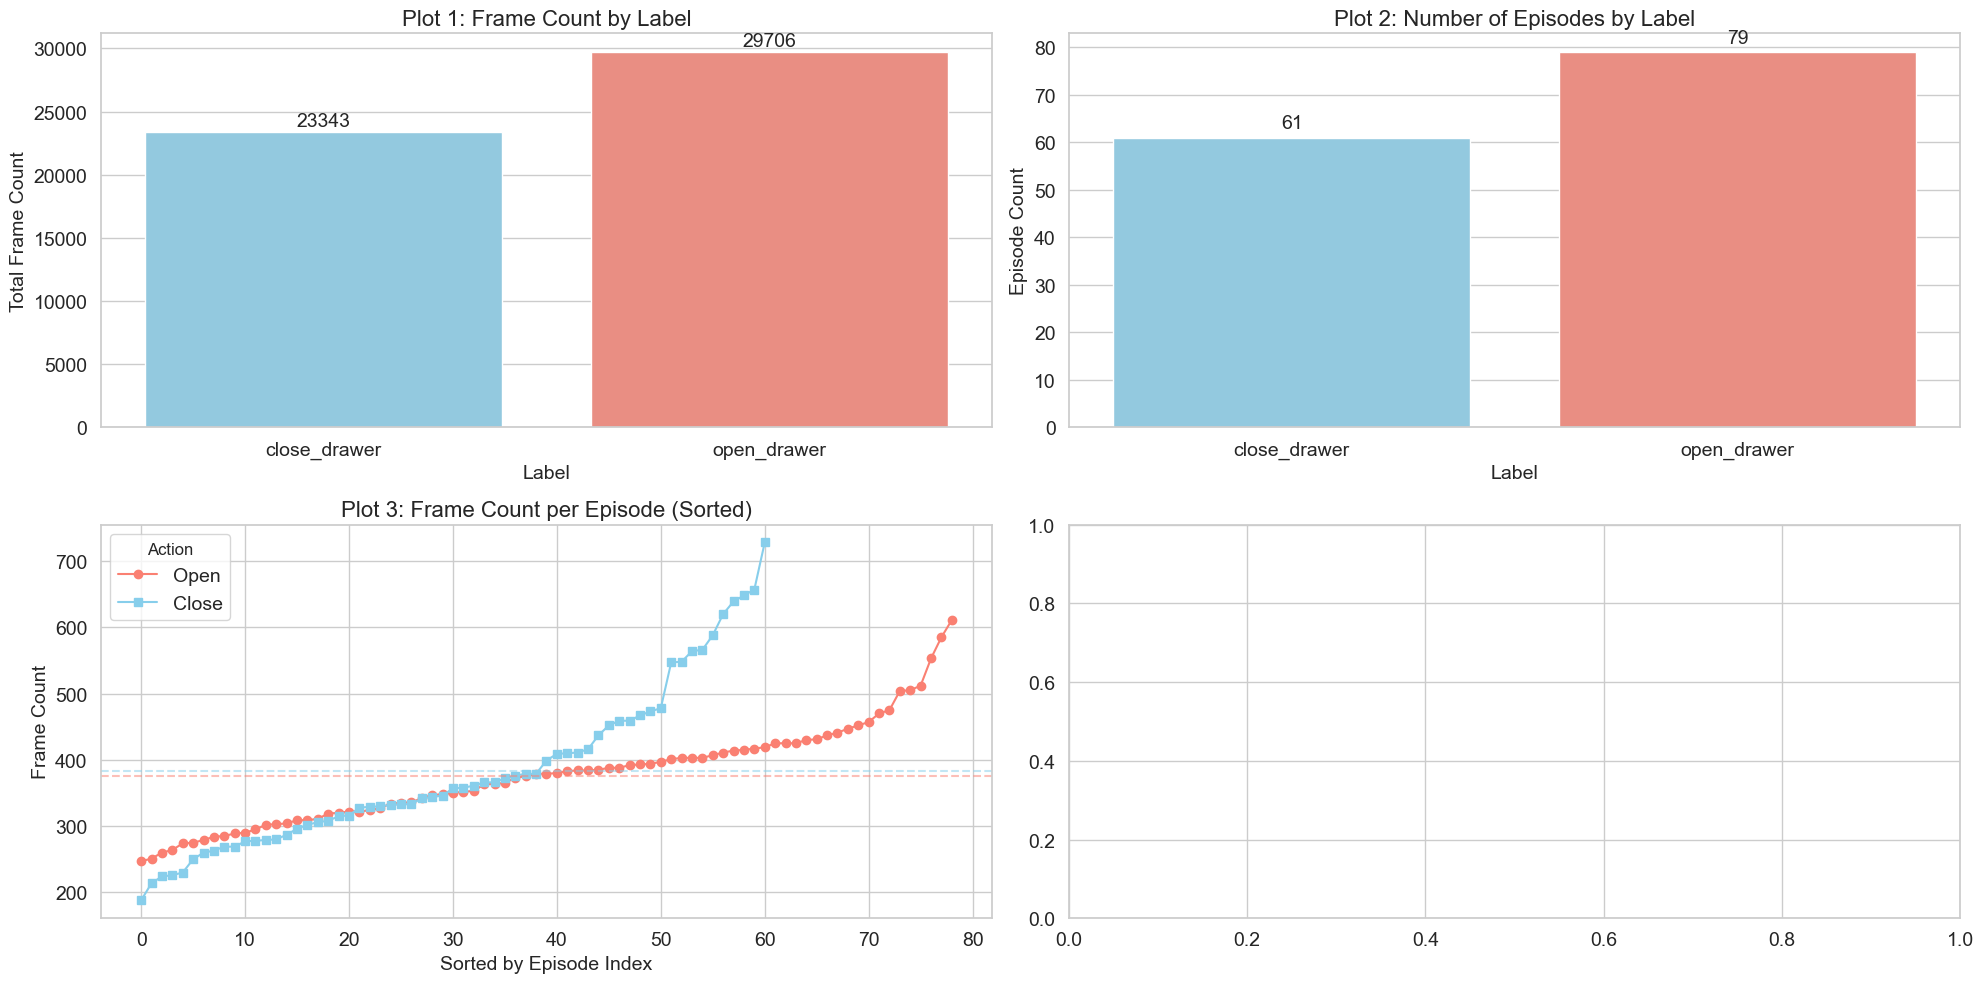

In [86]:
#---------------------------------------------------------------
# Visualize the dataset with 4 plots: frame count by label, number of episodes by label, 
# sorted frame count distribution, and KDE distribution of frame counts per episode.
#---------------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set global font sizes
TITLE_FONTSIZE = 16
AXIS_LABEL_FONTSIZE = 14
TICK_LABEL_FONTSIZE = 14
BAR_LABEL_FONTSIZE = 14

sns.set(style='whitegrid')
plt.rcParams.update({
    'axes.titlesize': TITLE_FONTSIZE,
    'axes.labelsize': AXIS_LABEL_FONTSIZE,
    'xtick.labelsize': TICK_LABEL_FONTSIZE,
    'ytick.labelsize': TICK_LABEL_FONTSIZE,
    'legend.fontsize': TICK_LABEL_FONTSIZE
})

# Map label index to label name
label_map = {0: 'open_drawer', 1: 'close_drawer'}
color_map = {'open_drawer': 'salmon', 'close_drawer': 'skyblue'}
index_color_map = {0: 'salmon', 1: 'skyblue'}

train_df['label_name'] = train_df['label_index'].map(label_map)

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# ===== Plot 1: Total frame count by label =====
frame_counts = train_df['label_name'].value_counts().sort_index()
colors_plot1 = [color_map[label] for label in frame_counts.index]
sns.barplot(x=frame_counts.index, y=frame_counts.values, ax=axes[0, 0], palette=colors_plot1)
axes[0, 0].set_title("Plot 1: Frame Count by Label")
axes[0, 0].set_ylabel("Total Frame Count")
axes[0, 0].set_xlabel("Label")
axes[0, 0].tick_params(axis='both', labelsize=TICK_LABEL_FONTSIZE)
for i, v in enumerate(frame_counts.values):
    axes[0, 0].text(i, v + 500, str(v), ha='center', fontsize=BAR_LABEL_FONTSIZE)

# ===== Plot 2: Number of episodes by label =====
episode_counts = train_df.drop_duplicates(['episode_index', 'label_name'])['label_name'].value_counts().sort_index()
colors_plot2 = [color_map[label] for label in episode_counts.index]
sns.barplot(x=episode_counts.index, y=episode_counts.values, ax=axes[0, 1], palette=colors_plot2)
axes[0, 1].set_title("Plot 2: Number of Episodes by Label")
axes[0, 1].set_ylabel("Episode Count")
axes[0, 1].set_xlabel("Label")
axes[0, 1].tick_params(axis='both', labelsize=TICK_LABEL_FONTSIZE)
for i, v in enumerate(episode_counts.values):
    axes[0, 1].text(i, v + 2, str(v), ha='center', fontsize=BAR_LABEL_FONTSIZE)

# ===== Plot 3: Frame count distribution (sorted) =====
frame_count_df = train_df.groupby(['label_name', 'episode_index']).size().reset_index(name='frame_count')
open_frames = frame_count_df[frame_count_df['label_name'] == 'open_drawer'].sort_values('frame_count')
close_frames = frame_count_df[frame_count_df['label_name'] == 'close_drawer'].sort_values('frame_count')

axes[1, 0].plot(open_frames['frame_count'].values, label='Open', marker='o', color=color_map['open_drawer'])
axes[1, 0].plot(close_frames['frame_count'].values, label='Close', marker='s', color=color_map['close_drawer'])
axes[1, 0].axhline(open_frames['frame_count'].mean(), linestyle='--', color=color_map['open_drawer'], alpha=0.5)
axes[1, 0].axhline(close_frames['frame_count'].mean(), linestyle='--', color=color_map['close_drawer'], alpha=0.5)
axes[1, 0].set_title('Plot 3: Frame Count per Episode (Sorted)')
axes[1, 0].set_xlabel('Sorted by Episode Index')
axes[1, 0].set_ylabel('Frame Count')
axes[1, 0].tick_params(axis='both', labelsize=TICK_LABEL_FONTSIZE)
axes[1, 0].legend(title='Action')
axes[1, 0].grid(True)

# ===== Plot 4: KDE distribution of frame counts per episode =====
episode_frame_counts = train_df.groupby(['label_index', 'episode_index']).size().reset_index(name='frame_count')

# Adjust layout and display
plt.tight_layout()
plt.show()


#### Visualizing Variable Dynamics

These visual tools together helped us identify informative variables (e.g., action_26, obs_state_12) and discard those lacking temporal or statistical variability.

(1) Raw Time-Series Curves

(2) Frame-Level Boxplots for all Variables

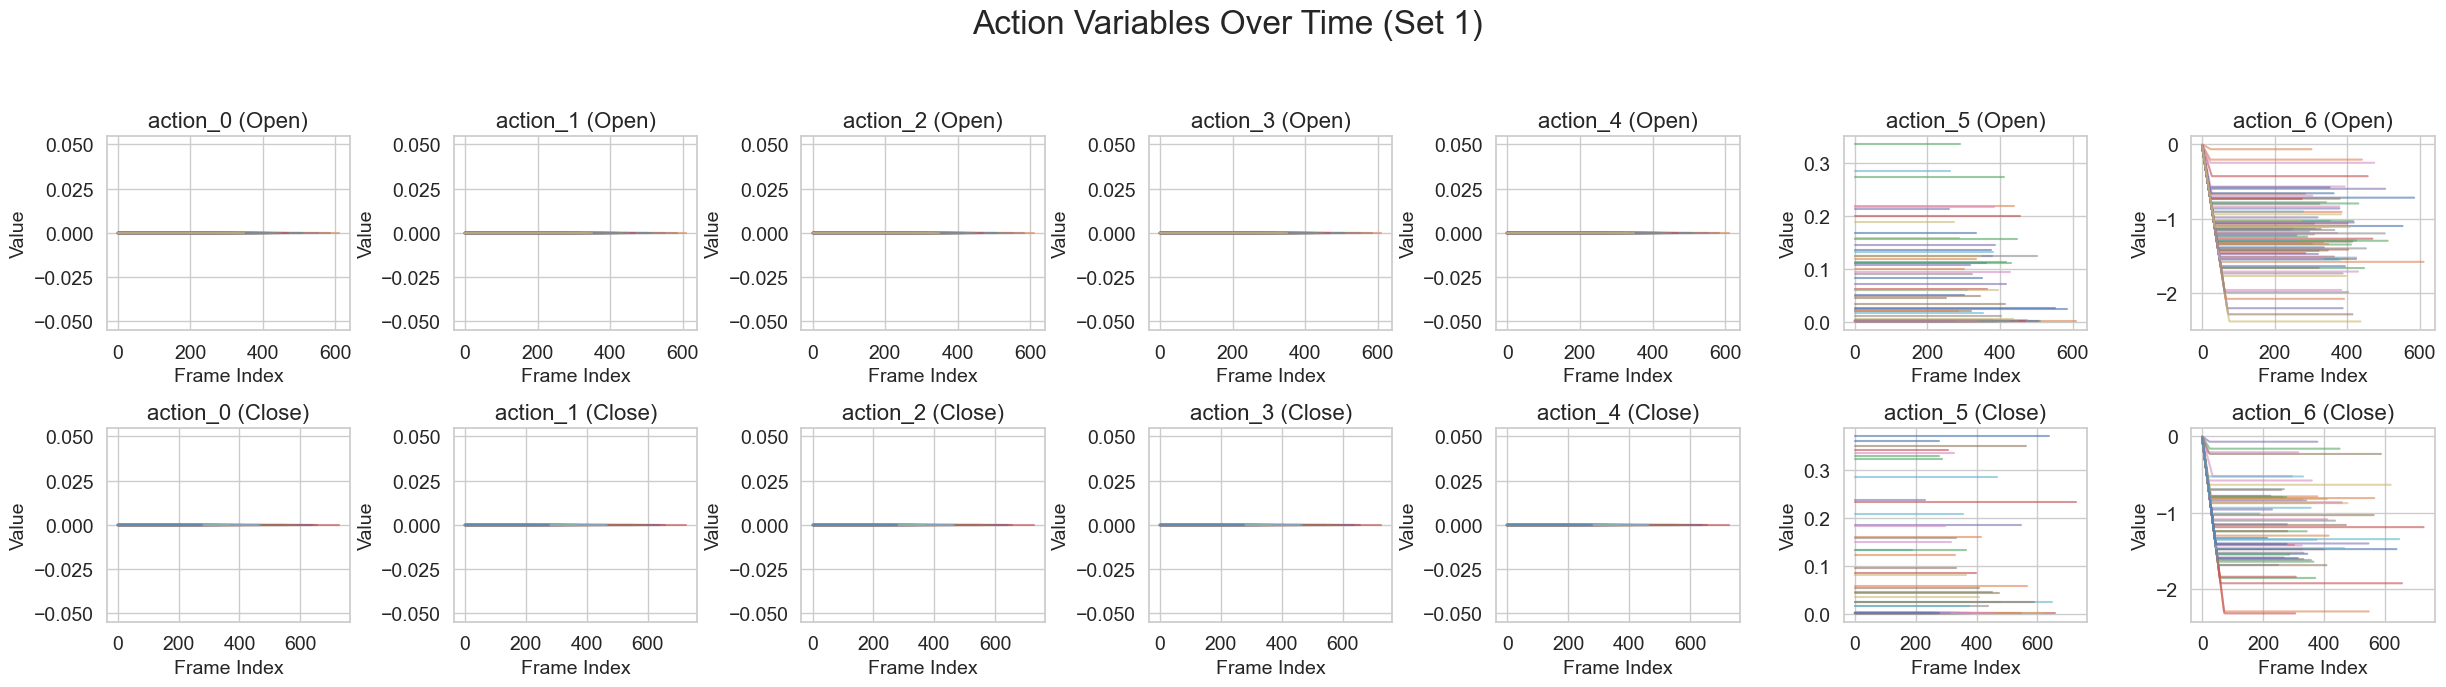

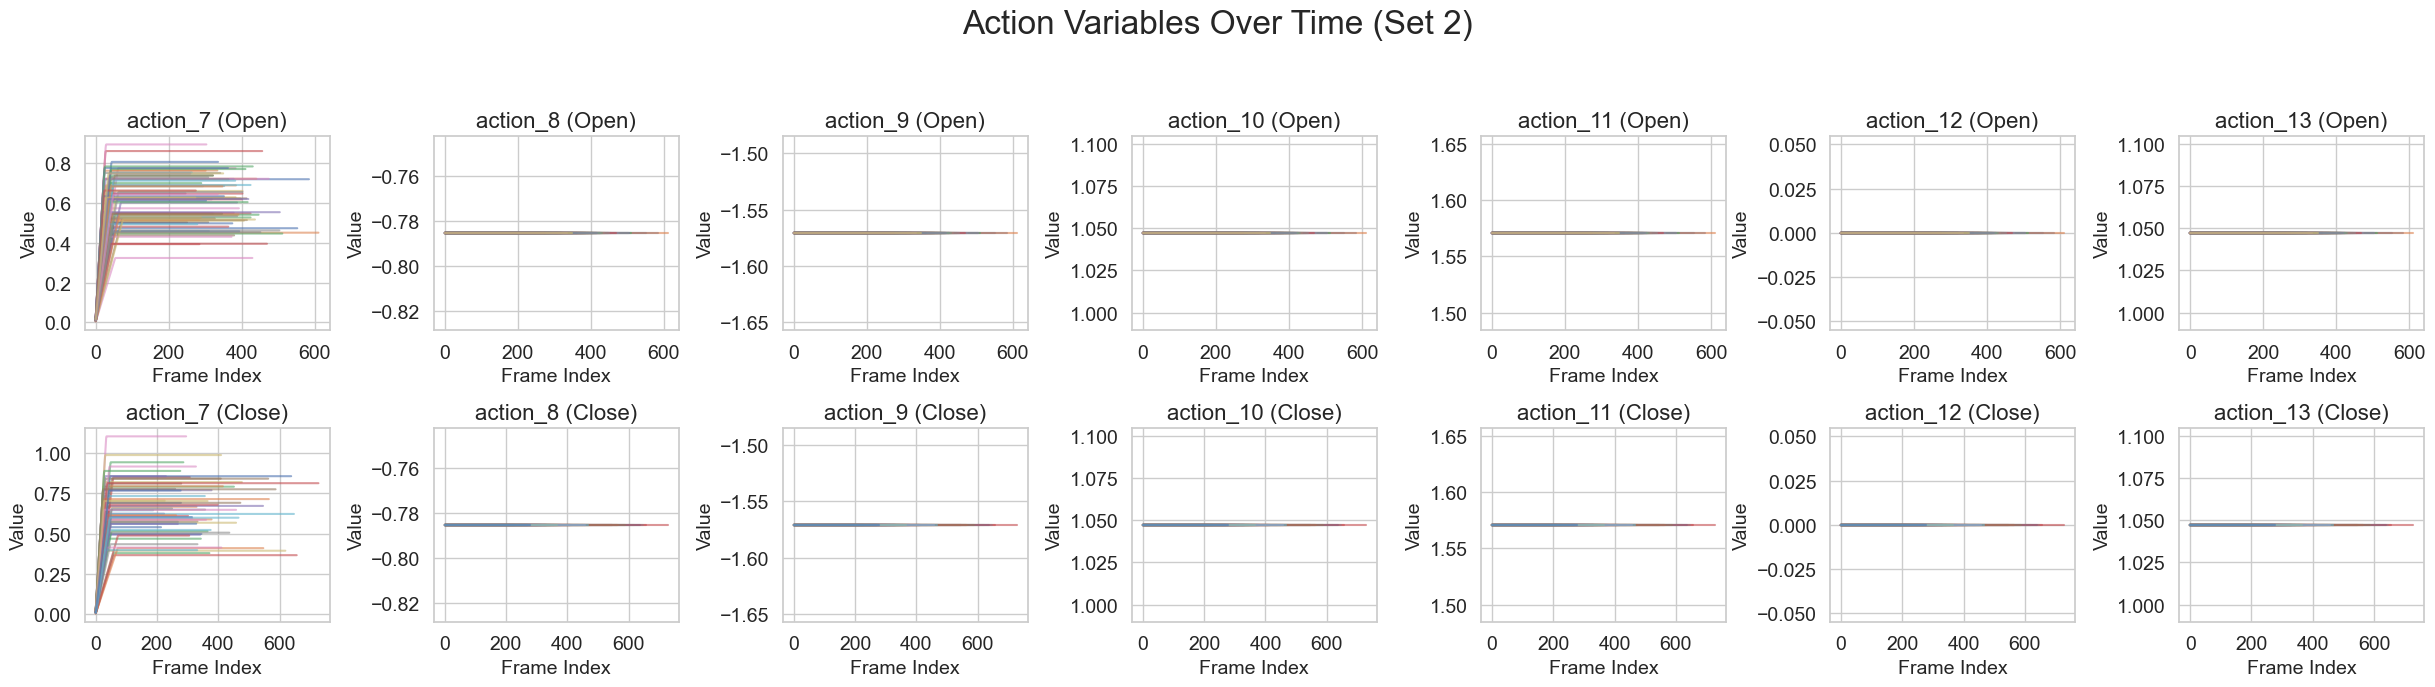

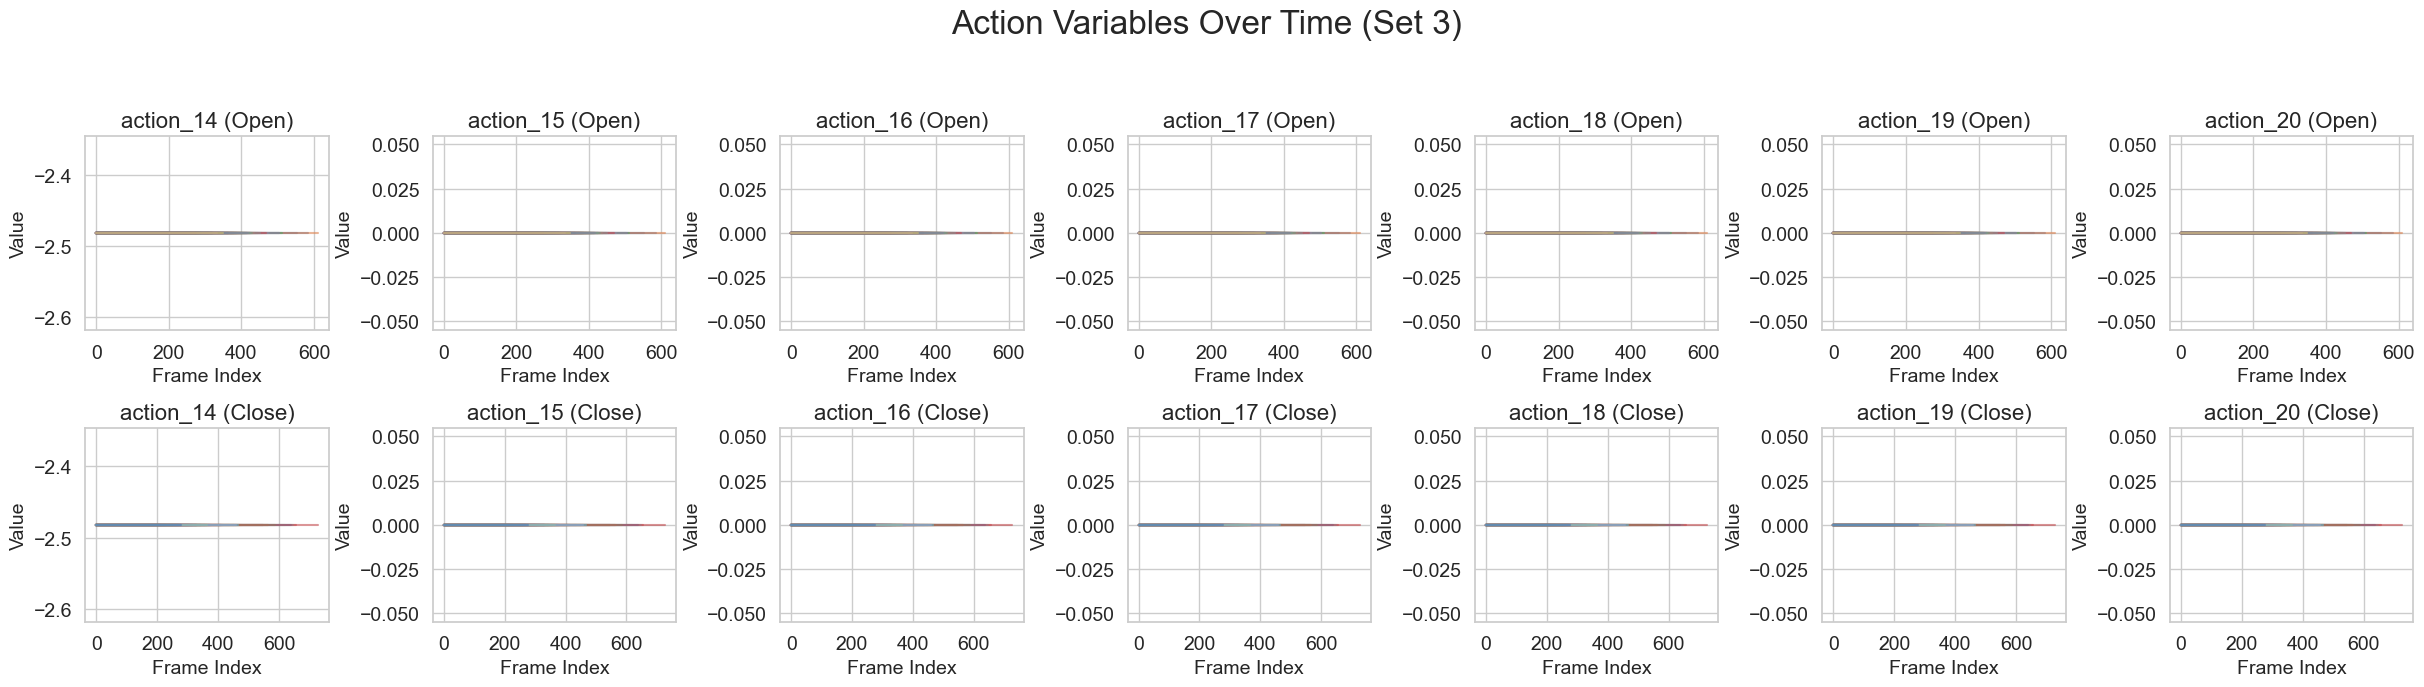

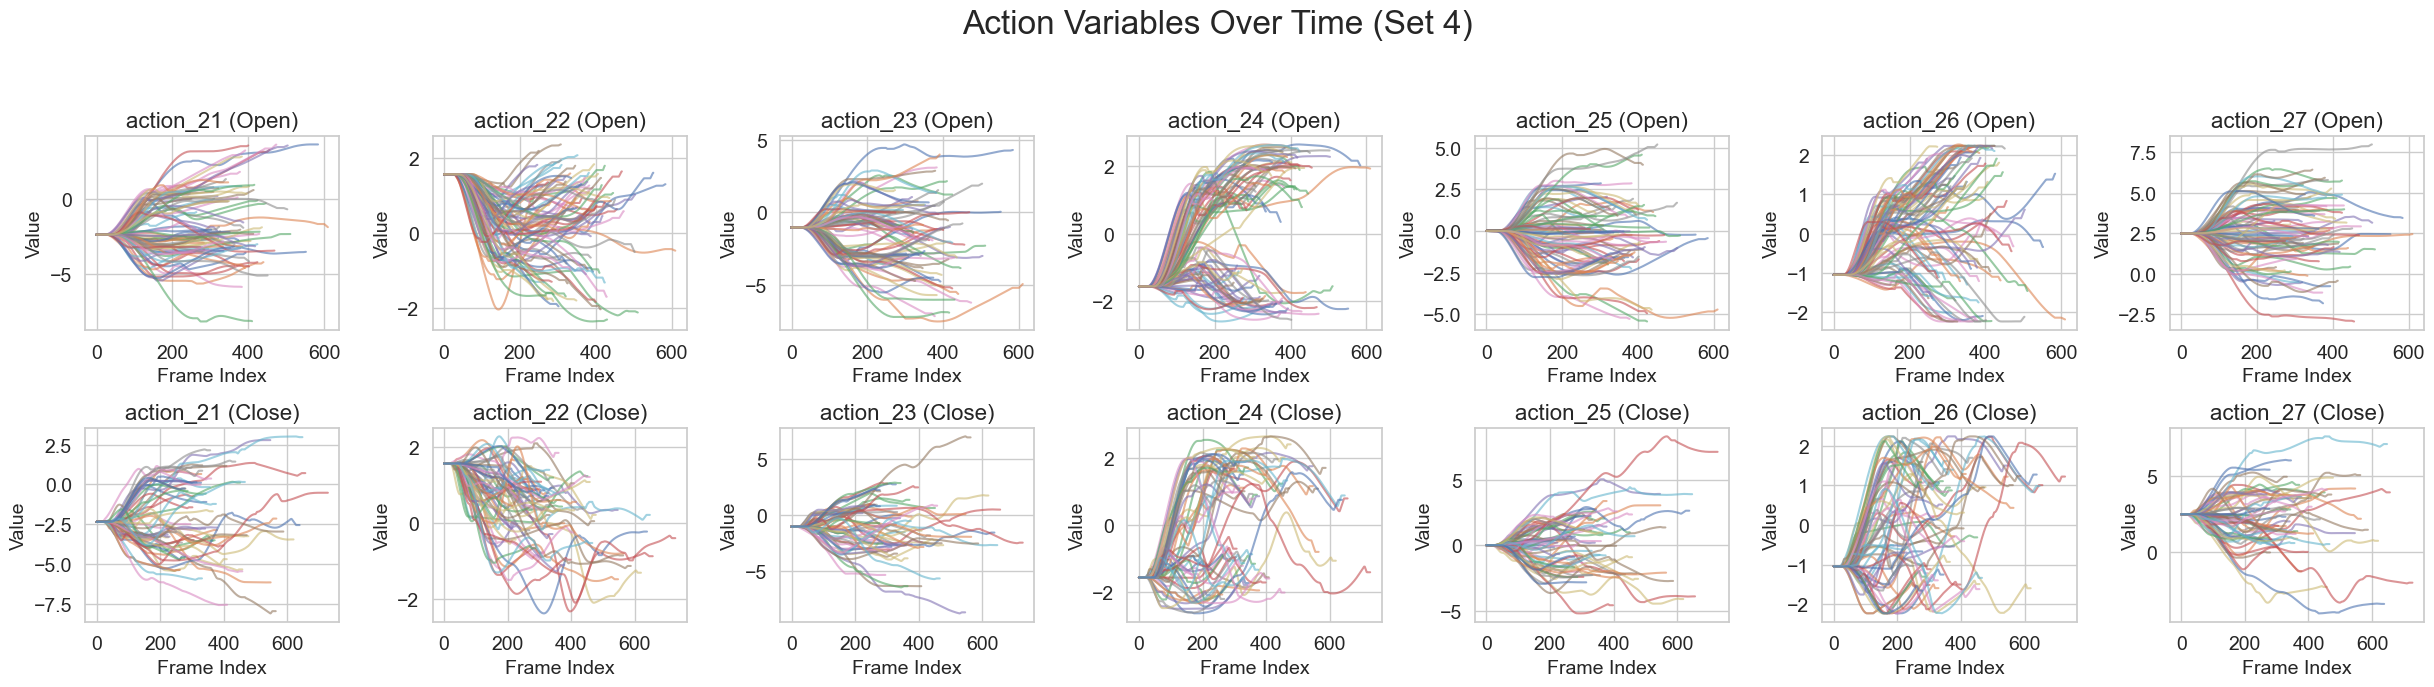

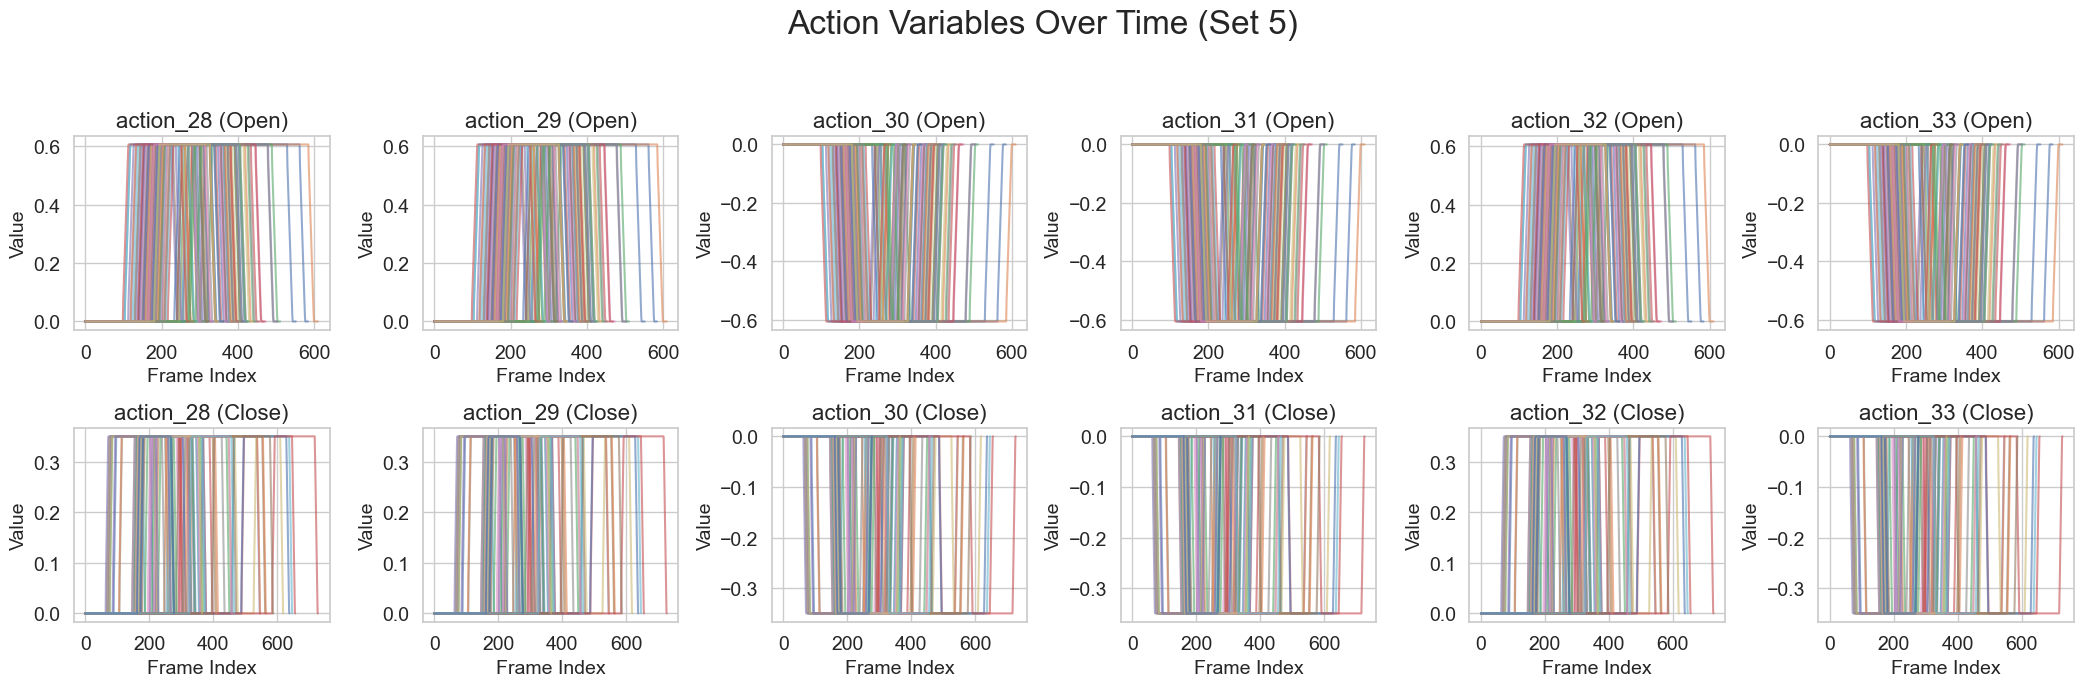

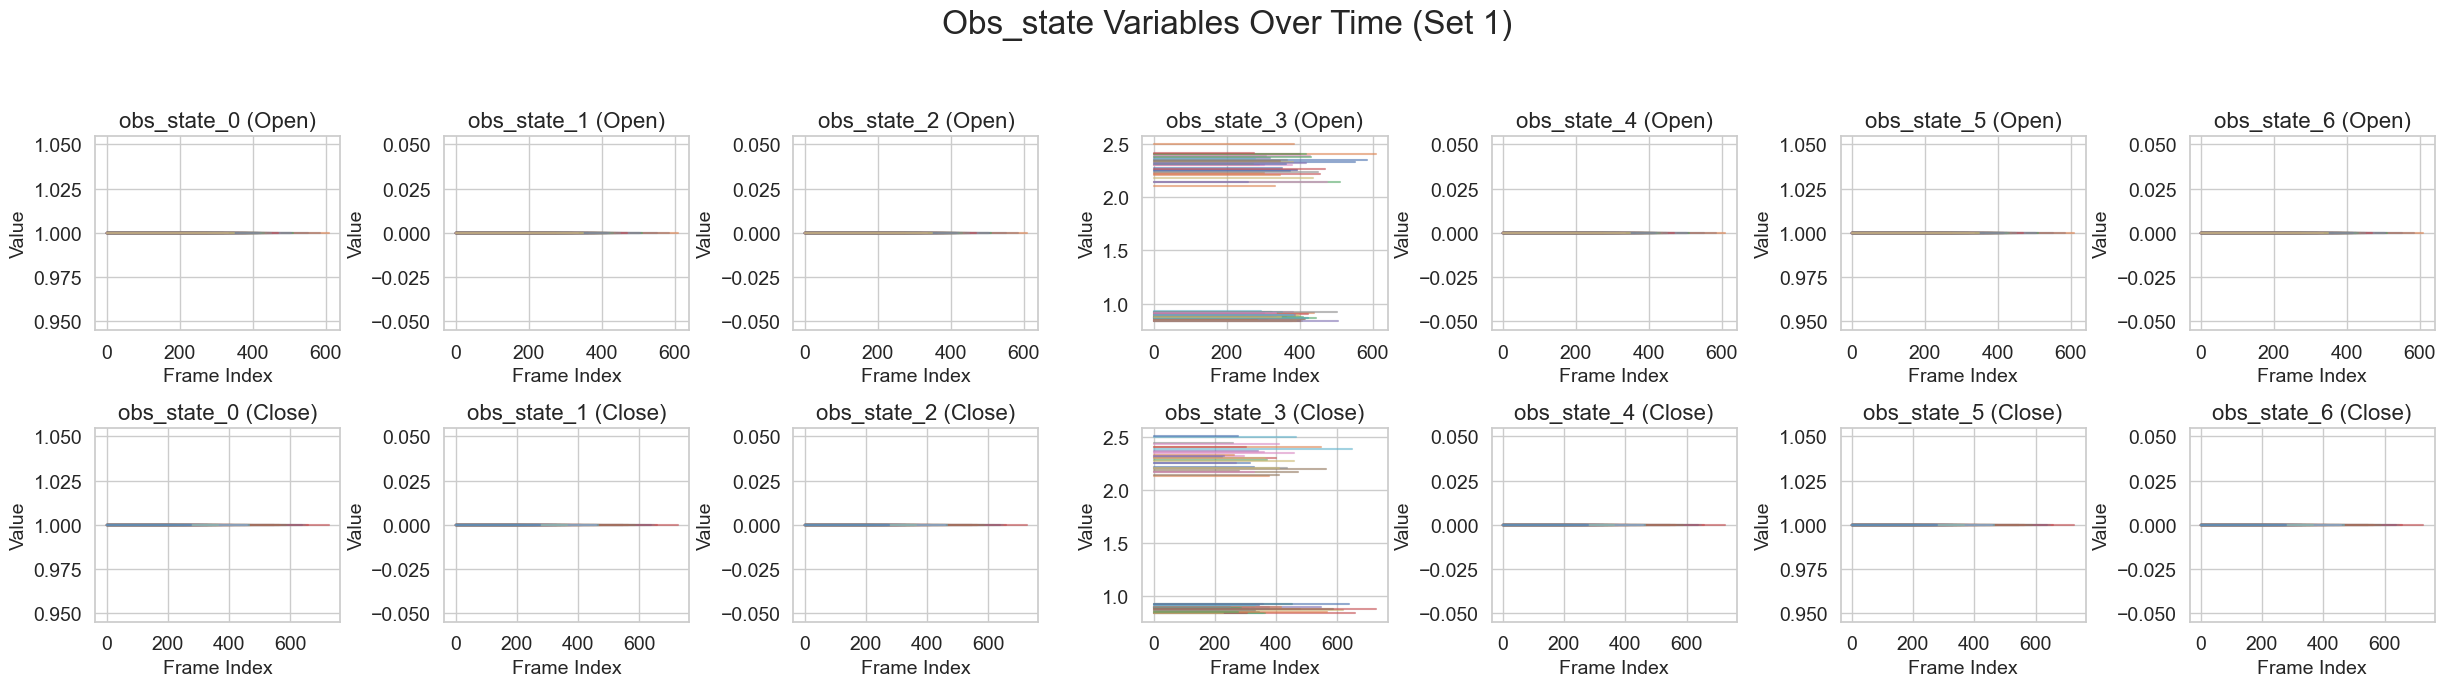

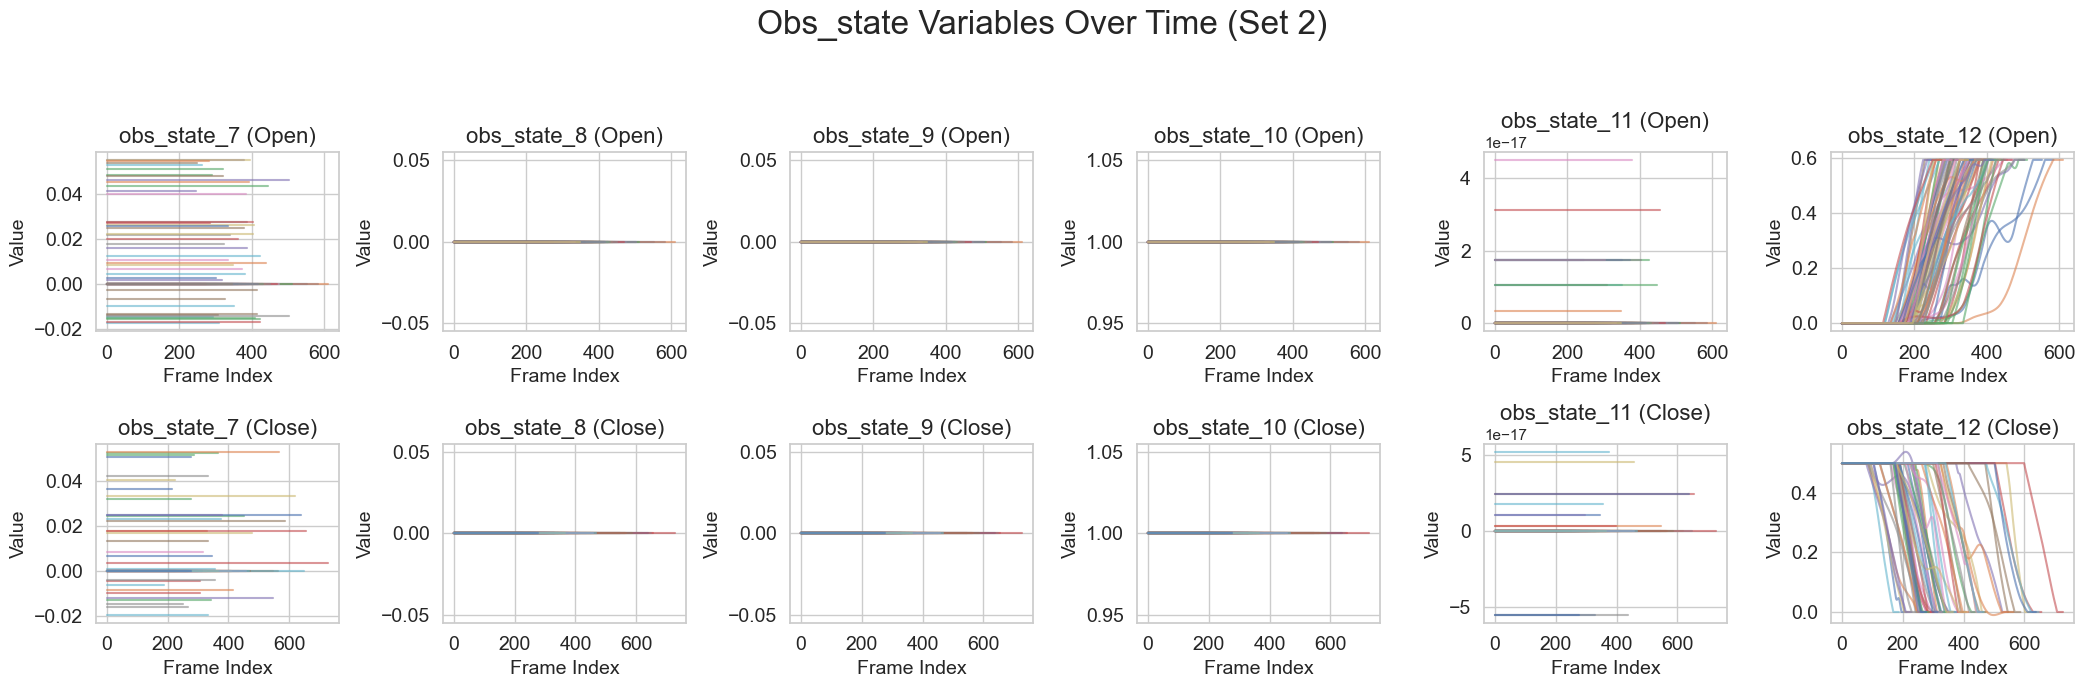

In [87]:
#---------------------------------------------------------------
# Raw Time-Series Curves
#---------------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

def plot_variables_by_group(df, prefix='action_', total_vars=34):
    """
    Plots variables (e.g., action_0 to action_33 or obs_stat_0 to obs_stat_12)
    in multiple pages of 2-row x 7-column subplots. Top = Open, Bottom = Close.
    """

    # ===== Font size settings =====
    TITLE_FONTSIZE = 24
    SUBTITLE_FONTSIZE = 16
    LABEL_FONTSIZE = 14
    TICK_FONTSIZE = 14

    sns.set(style='whitegrid')

    variable_names = [f'{prefix}{i}' for i in range(total_vars)]
    df_open = df[df['label_index'] == 0]
    df_close = df[df['label_index'] == 1]

    num_vars_per_page = 7
    num_pages = (total_vars + num_vars_per_page - 1) // num_vars_per_page

    for page in range(num_pages):
        start_idx = page * num_vars_per_page
        end_idx = min(start_idx + num_vars_per_page, total_vars)
        vars_subset = variable_names[start_idx:end_idx]

        fig, axes = plt.subplots(nrows=2, ncols=len(vars_subset), figsize=(3.5 * len(vars_subset), 7))
        fig.suptitle(f"{prefix[:-1].capitalize()} Variables Over Time (Set {page+1})", fontsize=TITLE_FONTSIZE)

        if len(vars_subset) == 1:
            axes = axes.reshape(2, 1)

        for col_idx, var in enumerate(vars_subset):
            # Open drawer subplot
            ax_open = axes[0, col_idx]
            for _, group in df_open.groupby('episode_index'):
                ax_open.plot(group['frame_index'], group[var], alpha=0.6)
            ax_open.set_title(f"{var} (Open)", fontsize=SUBTITLE_FONTSIZE)
            ax_open.set_xlabel("Frame Index", fontsize=LABEL_FONTSIZE)
            ax_open.set_ylabel("Value", fontsize=LABEL_FONTSIZE)
            ax_open.tick_params(axis='both', labelsize=TICK_FONTSIZE)
            ax_open.grid(True)

            # Close drawer subplot
            ax_close = axes[1, col_idx]
            for _, group in df_close.groupby('episode_index'):
                ax_close.plot(group['frame_index'], group[var], alpha=0.6)
            ax_close.set_title(f"{var} (Close)", fontsize=SUBTITLE_FONTSIZE)
            ax_close.set_xlabel("Frame Index", fontsize=LABEL_FONTSIZE)
            ax_close.set_ylabel("Value", fontsize=LABEL_FONTSIZE)
            ax_close.tick_params(axis='both', labelsize=TICK_FONTSIZE)
            ax_close.grid(True)

        plt.tight_layout(rect=[0, 0, 1, 0.93])  # leave space for suptitle
        plt.show()
        
plot_variables_by_group(train_df, prefix='action_', total_vars=34)
plot_variables_by_group(train_df, prefix='obs_state_', total_vars=13)


/var/folders/th/cyd7j44n6wbcg3b0g1fq45sr0000gn/T/ipykernel_13162/3805571.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label_index', y=var, data=train_df, ax=ax, palette="pastel")
/var/folders/th/cyd7j44n6wbcg3b0g1fq45sr0000gn/T/ipykernel_13162/3805571.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Open', 'Close'], fontsize=tick_fontsize)
/var/folders/th/cyd7j44n6wbcg3b0g1fq45sr0000gn/T/ipykernel_13162/3805571.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label_index', y=var, data=train_df, ax=ax, palette="pastel")
/var/folders/th/cyd7j44n6wbcg3b0g1fq45sr0000gn

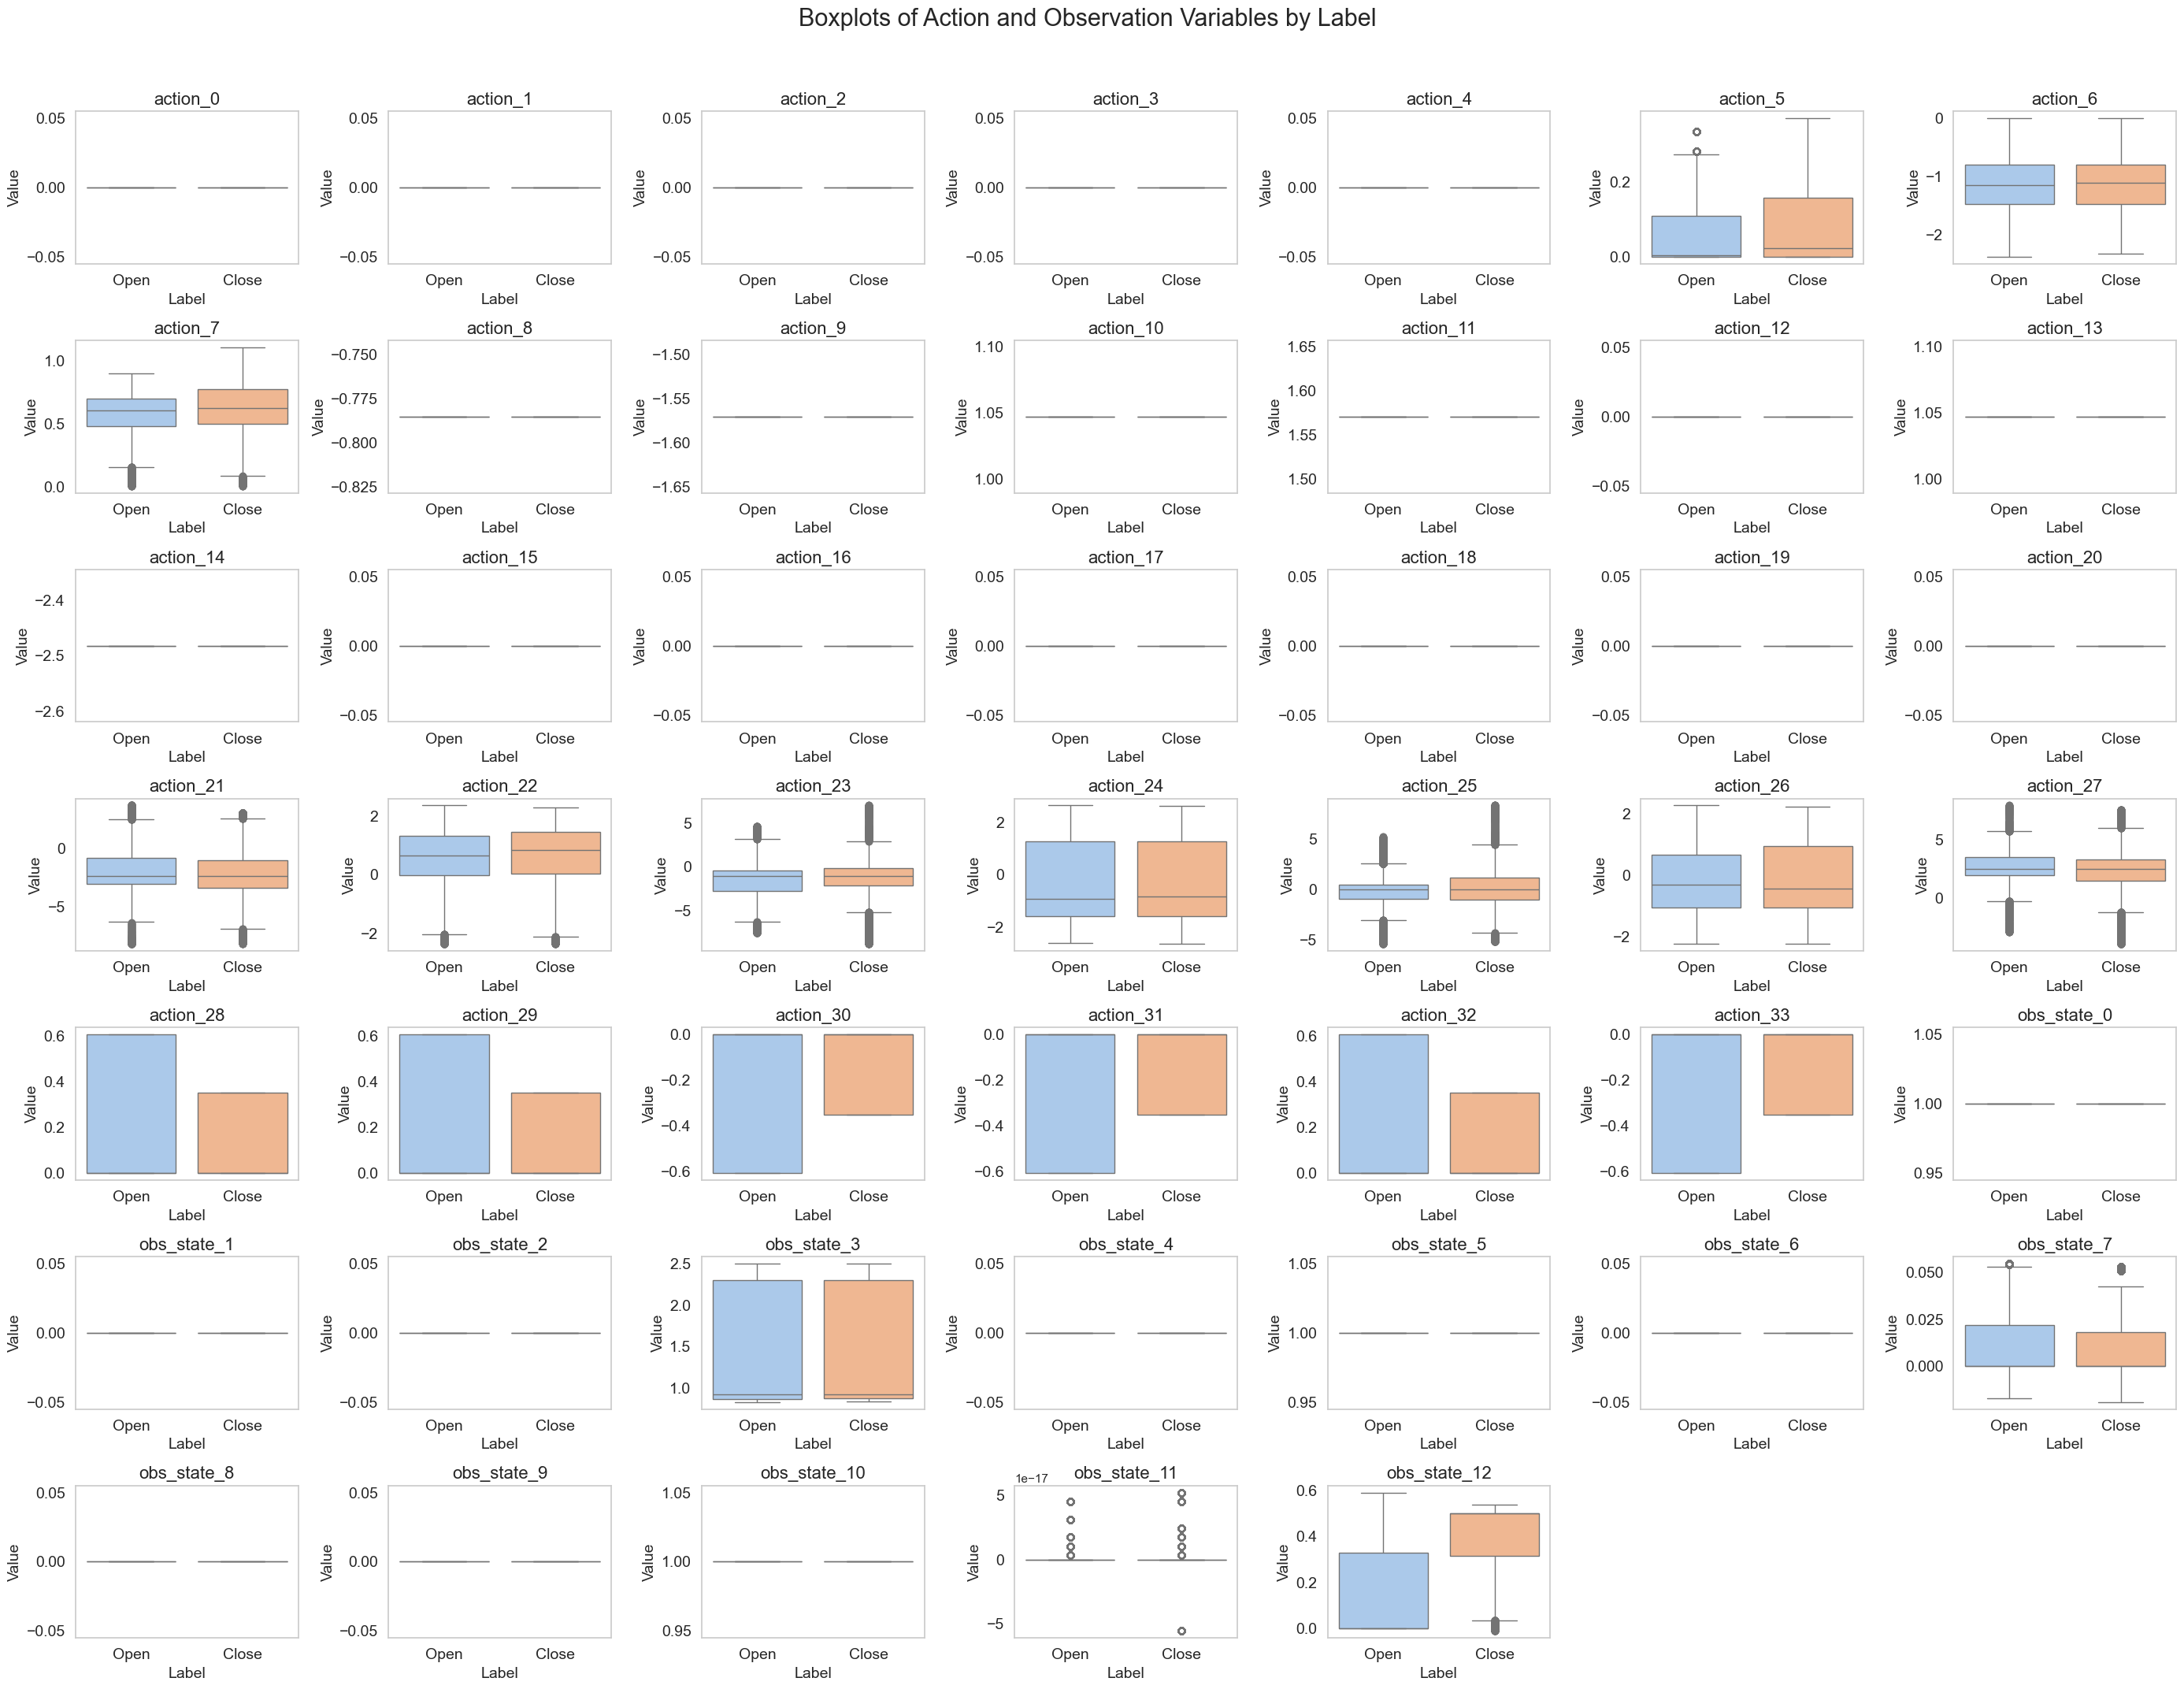

In [88]:
#---------------------------------------------------------------
# Frame-Level Boxplots
#---------------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

def plot_all_boxplots(train_df, action_range=(0, 33), obs_range=(0, 12),
                      plots_per_row=7, figsize_per_plot=(4, 3), suptitle="Boxplots of Variables by Label"):
    """
    Plot boxplots for action_0~33 and obs_state_0~12, showing both label_index=0 and 1 in the same plot.
    """

    # Set font sizes
    title_fontsize = 16
    xlabel_fontsize = 14
    ylabel_fontsize = 14
    tick_fontsize = 14
    suptitle_fontsize = 22

    # Create list of all variable names
    action_vars = [f'action_{i}' for i in range(action_range[0], action_range[1] + 1)]
    obs_vars = [f'obs_state_{i}' for i in range(obs_range[0], obs_range[1] + 1)]
    all_vars = action_vars + obs_vars

    # Total number of plots
    num_vars = len(all_vars)
    num_rows = math.ceil(num_vars / plots_per_row)

    # Set up figure
    fig, axes = plt.subplots(num_rows, plots_per_row,
                             figsize=(figsize_per_plot[0]*plots_per_row, figsize_per_plot[1]*num_rows))
    axes = axes.flatten()  # Flatten axes for easy indexing

    # Set overall title
    fig.suptitle(suptitle, fontsize=suptitle_fontsize, y=1.02)

    # Plot each variable
    for i, var in enumerate(all_vars):
        ax = axes[i]
        sns.boxplot(x='label_index', y=var, data=train_df, ax=ax, palette="pastel")

        ax.set_title(var, fontsize=title_fontsize)
        ax.set_xticklabels(['Open', 'Close'], fontsize=tick_fontsize)
        ax.set_xlabel("Label", fontsize=xlabel_fontsize)
        ax.set_ylabel("Value", fontsize=ylabel_fontsize)
        ax.tick_params(axis='y', labelsize=tick_fontsize)
        ax.grid(False)

    # Remove unused axes if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Example usage
plot_all_boxplots(train_df, suptitle="Boxplots of Action and Observation Variables by Label")


### Feature Engineering

#### 1. Choose Variables

**(1). Removing Static Variables**
  - Variables exhibiting meaningful frame-wise dynamics and likely involvement in drawer manipulation were initially retained, specifically `action_21–action_33`, `obs_state_12` and `total_frame`.

 **(2). Reduce Redundancy**
  - To minimize dimensionality and remove redundancy, we examined variable trajectories and observed that the sets {`action_28`, `action_29`, `action_32`} and {`action_30`, `action_31`, `action_33`} shared nearly identical temporal profiles. Accordingly, `action_28` and `action_30` were selected as representative variables.

**(3). Final Selected Variables**
 - `action_21–action_27`, `action_28`, `action_30`, `obs_state_12`, and `total_frame`.

 **(4). Removed Static Variables**

| **Variable**      | **Reason for Removal**                                                                |
|-------------------|---------------------------------------------------------------------------------------|
| `action_0~4`      | base / wheels, constant across frames, unrelat∏ed to drawer action                     |
| `action_5`        | Torso lift, constant per episode, unrelated to drawer action                 |
| `action_6`, `7`   | Head camera controls, stable throughout, unrelated to physical drawer manipulation    |
| `action_8~20`     | Left arm(arm/finger/knuckle joints), constant across frames                           |
| `obs_state_0~2`, `4~6` , `8~10`    | projection of drawer orientation (rotation matrix component), constant across frames                                             |
| `obs_state_3`, `7` , `11`      | Drawer position along x, y ,z-axis (position vector), constant across frames                           |



#### 2. Computing Episode-Level Statistical Features

| Variable Name                          | Raw Time-Series Curve Characteristics                | Statistical Features                  | Selection Reason                                                                                                                         |
|----------------------------------------|----------------------------------------------------|---------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------|
| action_21 ~ action_27 <br>(right arm main joints) <br><br> | Clear monotonic trends, large variation range, <br>with some local oscillations <br><br> | mean, range, slope, end_value, <br>diff1_mean, diff2_std <br><br> | Represents: <br>- Overall posture level (mean) <br>- Action amplitude (range) <br>- Trend direction (slope) <br>- Final control state (end_value) <br>- Average local slope change (diff1_mean) <br>- Oscillation degree (diff2_std) <br><br> |
| action_28, action_30 <br>(right arm fingers joints) <br><br> | Values mostly show sudden jumps between 0 and a small constant, <br>with clear start and stop points,<br>and stay flat in between, overall change is small. <br><br> | mean, range, duration_nonzero <br><br> | Represents: <br>- Overall activation status (mean) <br>- Extent of its motion. (range) <br>- Action activation duration (duration_nonzero) <br><br> |
| obs_state_12 <br>(End-effector / drawer position) <br><br> | Clear linear trend: increases during opening, decreases during closing; <br>sharp, smooth, mirror-like between two classes. <br><br> |  start_value, end_value  <br><br> |Captures: <br>- Start/end differences <br>(for state transition analysis) <br><br> |
| total_frame <br><br> | Single scalar value per episode; reflects total duration. <br><br> | None (raw value used directly) <br><br> | Indicates task execution length and complexity. <br><br> |

#### 3. Remove Constant Features and Standardization

| Steps                                          | Description                                                                                     | Purpose                                                                                   |
|------------------------------------------------|-------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------|
| Step 1: Remove constant features               | Drop features that contain only zeros <br>or have no variance.                                      | Reduce noise and eliminate useless inputs.                                                |
| Step 2: Feature Standardization                | Rescale numeric features to zero mean <br>and unit variance (Z-score).                              | Ensure fair contribution across features; <br>required for distance-based/linear models.       |

In [89]:
#-----------------------------------
#-----------------------------------
# Episode Level Feature Computation
#-----------------------------------
#-----------------------------------

import pandas as pd
import numpy as np

def compute_episode_level_features(train_df):
    # List of variable groups
    action_vars_21_27 = [f'action_{i}' for i in range(21, 28)]
    action_vars_28_30= ['action_28', 'action_30']
    obs_vars = ['obs_state_12']
    all_vars = action_vars_21_27 + action_vars_28_30 + obs_vars

    episode_features = []
    missing_rate_dict = {var: [] for var in all_vars}

    # Group by episode and label index
    for (episode_index, label_index), group in train_df.groupby(['episode_index', 'label_index']):
        episode_data = {
            'episode_index': episode_index,
            'label_index': label_index,
            'total_frame': len(group)  # Total number of frames in the episode
        }

        for var in all_vars:
            values = group[var].values
            missing_ratio = np.isnan(values).sum() / len(values)
            missing_rate_dict[var].append(missing_ratio)

            # -----------------------
            # For action_21 to action_27
            # -----------------------
            if var in action_vars_21_27:
                episode_data[f'{var}_mean'] = np.nanmean(values)
                episode_data[f'{var}_range'] = np.nanmax(values) - np.nanmin(values)
                episode_data[f'{var}_end_value'] = values[-1] if len(values) > 0 else np.nan
                episode_data[f'{var}_slope'] = (values[-1] - values[0]) / len(values) if len(values) > 1 else 0
                episode_data[f'{var}_diff1_mean'] = np.nanmean(np.diff(values)) if len(values) > 1 else np.nan
                episode_data[f'{var}_diff2_std'] = np.nanstd(np.diff(values, n=2)) if len(values) > 2 else np.nan
                

            # -----------------------
            # For action_28 to action_30
            # -----------------------
            elif var in action_vars_28_30:
                episode_data[f'{var}_mean'] = np.nanmean(values)
                episode_data[f'{var}_range'] = np.nanmax(values) - np.nanmin(values)
                episode_data[f'{var}_duration_nonzero'] = np.sum(values != 0) / len(values) if len(values) > 0 else np.nan

            # -----------------------
            # For obs_state_12
            # -----------------------
            elif var == 'obs_state_12':
                episode_data[f'{var}_start_value'] = values[0] if len(values) > 0 else np.nan
                episode_data[f'{var}_end_value'] = values[-1] if len(values) > 0 else np.nan


        episode_features.append(episode_data)

    episode_stats_df = pd.DataFrame(episode_features)

    # Report missing value rates
    print("Missing Value Report:")
    has_missing = False
    for var, rates in missing_rate_dict.items():
        avg_missing = np.mean(rates)
        if avg_missing > 0:
            has_missing = True
            print(f"  {var}: missing rate = {avg_missing:.2%}")
    if not has_missing:
        print("  All variables have 0 missing rate.")

    return episode_stats_df

# Example usage
episode_features_df = compute_episode_level_features(train_df)



#----------------------------------------------
#----------------------------------------------
# Remove constant features and Standardization
#---------------------------------------------
#---------------------------------------------

# Step 1: Remove constant features  

def drop_constant_features(df):
    """
    Find and drop columns that are either always zero OR have no variance (constant values).
    Prints a summary table and returns a cleaned DataFrame.

    Parameters
    ----------
    df : pd.DataFrame

    Returns
    -------
    df_cleaned : pd.DataFrame
        New DataFrame with constant features removed.
    """
    # Find constant features (all-zero OR no variance)
    constant_vars = {
        'zero_vars': [col for col in df.columns if (df[col] == 0).all()],
        'no_variance_vars': [col for col in df.columns if df[col].nunique() == 1]
    }
    
    # Combine and deduplicate
    all_constant_vars = list(set(constant_vars['zero_vars'] + constant_vars['no_variance_vars']))
    
    # Print report
    if all_constant_vars:
        print("\nConstant Features Removed:")
        print("+--------+----------------------+-------------------+")
        print("| Index  | Variable             | Type              |")
        print("+--------+----------------------+-------------------+")
        
        for i, var in enumerate(all_constant_vars, start=1):
            idx = str(i).ljust(6)
            name = var.ljust(20)
            var_type = "All Zeros" if var in constant_vars['zero_vars'] else "No Variance"
            print(f"| {idx} | {name} | {var_type.ljust(17)} |")
        
        print("+--------+----------------------+-------------------+")
        print(f"Total removed: {len(all_constant_vars)} columns")
    else:
        print("No constant features found (no all-zero or no-variance columns).")

    # Drop and return
    # Return DataFrame with those columns dropped
    episode_features_df_no_constant_var = df.drop(columns=all_constant_vars)
    return episode_features_df_no_constant_var

# Usage
episode_features_df_no_constant_var = drop_constant_features(episode_features_df) #episode_features_df_no_constant_var means no constant variable



# Step 2 : Standardization

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def process_and_standardize_features(X, scaler=None):
    """
    Standardizes the features using StandardScaler.

    Parameters:
        X (DataFrame): numeric features to standardize
        scaler (StandardScaler or None): provide a pre-fitted scaler for test data

    Returns:
        X_scaled (DataFrame): standardized features
        scaler (StandardScaler): fitted or reused scaler object
    """

    # Standardization only
    if scaler is None:
        scaler = StandardScaler()
        X_scaled_array = scaler.fit_transform(X)
    else:
        X_scaled_array = scaler.transform(X)

    X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns, index=X.index)
    return X_scaled, scaler

# Input
X_train = episode_features_df_no_constant_var.drop(columns=['episode_index', 'label_index']) 
y_train = episode_features_df['label_index']

# Standardize features
X_train_scaled, train_scaler = process_and_standardize_features(X_train)

# Save the scaler for future use
import joblib
joblib.dump(train_scaler, "trained_models/train_scaler.pkl")

print(X_train_scaled.shape)
X_train_scaled.head()


Missing Value Report:
  All variables have 0 missing rate.
No constant features found (no all-zero or no-variance columns).
(140, 51)


,total_frame,action_21_mean,action_21_range,action_21_end_value,action_21_slope,action_21_diff1_mean,action_21_diff2_std,action_22_mean,action_22_range,action_22_end_value,action_22_slope,action_22_diff1_mean,action_22_diff2_std,action_23_mean,action_23_range,action_23_end_value,action_23_slope,action_23_diff1_mean,action_23_diff2_std,action_24_mean,action_24_range,action_24_end_value,action_24_slope,action_24_diff1_mean,action_24_diff2_std,action_25_mean,action_25_range,action_25_end_value,action_25_slope,action_25_diff1_mean,action_25_diff2_std,action_26_mean,action_26_range,action_26_end_value,action_26_slope,action_26_diff1_mean,action_26_diff2_std,action_27_mean,action_27_range,action_27_end_value,action_27_slope,action_27_diff1_mean,action_27_diff2_std,action_28_mean,action_28_range,action_28_duration_nonzero,action_30_mean,action_30_range,action_30_duration_nonzero,obs_state_12_start_value,obs_state_12_end_value
0,2.09351639911110520842,2.46023335465885084616,2.47235348686635214577,2.23260899122791567351,1.41141885495806040929,1.40969931463374220648,-0.68331199110665186147,-0.20772866149590327178,0.30389308297933714798,0.89646082952641381603,0.92888411176648477685,0.92873974455067764833,-0.50047260295915041439,2.76506457195147836714,2.11734006125469909065,2.21696855296201800201,1.46203261437366949238,1.46034612813486086580,-0.37516738221540907317,1.57691840669225258331,1.28845058821346025724,1.10270784694711432294,0.37028648677145176160,0.36886228507537860422,-0.23379584579510104270,-1.06104880277219915108,0.33644498506620967859,-0.16354102813027460162,-0.09759653278491019213,-0.09746801179715192109,-0.74423546818280039705,0.82443732171988581836,0.44302946973841605960,0.91292910390378612107,0.26332413608486526790,0.26207623865014184616,-0.64317954021967693734,1.09309590880616225306,0.45172587409718834017,0.47595528241293177940,0.31702757294715433467,0.31671073461939197591,-0.28453127029373181944,1.20325082687366768930,0.87872174135739733458,0.61172489614487968179,-1.20325082687366768930,0.87872174135739733458,0.61172489614487968179,-0.87872174135739766765,0.87872174135739755663
1,-1.67540813625442130963,-0.73128594807661706501,-0.67828824865616110795,-0.78463267668117209208,-1.22230770299749602614,-1.22411422678241410544,1.60845743402328711369,0.75115959167377899242,-0.71647833127551563415,0.13064519680921188316,-0.54387779966400506826,-0.54649849010427453688,1.12077923966832115887,0.73846107201033883705,-0.66617251075007832828,0.71587249276257880481,1.15473755675701617029,1.15657595851033567769,1.98642424957890506576,-0.84405075590961120557,-1.51870040368855163671,-0.77512517114616863445,-0.58482445649715275593,-0.58398610008419771233,0.80053494243863709823,0.04290269044700235207,-1.37250587122051714850,-0.02576329904584109473,-0.08261477961916208201,-0.08287667957245843653,-0.50735626414192180889,-0.93874165818930455085,-1.29619242103649656705,-0.49117512293301779369,-0.21573789465073386906,-0.21459230262312117832,0.85702333616403292282,-0.07757988702394534586,-1.38539494400244511674,-0.04092126040313748270,-0.05425949175572608585,-0.05430220016302592101,-1.06792399541158067322,-0.37703418664964799545,-1.13801668143007250755,0.77258423190460279173,0.37703418664964799545,-1.13801668143007250755,0.77258423190460279173,1.13801668143007228551,-1.13801668143007206346
2,0.63064542042475524308,-1.63034940495887092915,0.56242377082355654583,-0.97356102359290941362,-0.86586498008693191242,-0.86542014007289291833,0.23046433797079998729,-0.33818223588729690032,1.95184794978940523436,0.48859801915631417835,0.56546188626298599100,0.56560858686645987259,0.33984968402301218848,-1.62179694661406803569,1.33642325628628744205,-1.67642924118357394825,-1.47968686099255841704,-1.47895888125773367072,0.78273708366905259126,-0.54160646715522464678,-0.77409489105086060068,-1.09795811992750658170,-1.06130311560305501395,-1.06113174884011129961,-0.88570588314905318583,0.66015259777951285081,-0.18572648417149140165,0.58400129248840648710,0.5397

### Model Training and Evaluation

#### Test Metrics Summary



| **Metric**     | **Purpose**                                                                 | **Formula**                                                        | **Parameters**                                                                            |
|----------------|------------------------------------------------------------------------------|----------------------------------------------------------------------|--------------------------------------------------------------------------------------------|
| **Accuracy**   | Overall correctness of predictions                                           | (TP + TN) / (TP + TN + FP + FN)                                     | TP = True Positives<br>TN = True Negatives<br>FP = False Positives<br>FN = False Negatives |
| **AUC-ROC**    | Ability to distinguish positive and negative classes                        | Area under the ROC curve (TPR vs FPR)                               | TPR = TP / (TP + FN)<br>FPR = FP / (FP + TN)<br>Range: 0.5 (random) to 1.0 (perfect)        |
| **F1 Score**   | Balance between precision and recall (useful for imbalanced data)           | 2 × (Precision × Recall) / (Precision + Recall)                     | Precision = TP / (TP + FP)<br>Recall = TP / (TP + FN)                                      |
| **Precision**  | Proportion of predicted positives that are correct                          | TP / (TP + FP)                                                      | TP = True Positives<br>FP = False Positives                                                |
| **Recall**     | Proportion of actual positives that are correctly predicted                 | TP / (TP + FN)                                                      | TP = True Positives<br>FN = False Negatives                                                |


#### Model 1: Logistic Regression

##### (1) Model Definition

Logistic regression is a binary classification model used to predict the probability of an event occurring, $P(Y = 1 \mid \mathbf{x})$.

**Model Formula**
$$
P(Y = 1 \mid \mathbf{x}) = \frac{1}{1 + e^{-\mathbf{x}^T \boldsymbol{\beta}}}
$$

Where:
- $\mathbf{x}$: Input variables  
- $\boldsymbol{\beta}$: Model parameters  
- The Sigmoid function maps the linear function to a probability value



**Log-Odds Form**
$$
\log \left( \frac{P(Y = 1)}{1 - P(Y = 1)} \right) = \mathbf{x}^T \boldsymbol{\beta}
$$

This indicates that the log-odds of the outcome is linearly related to the input variables.



**Parameter Estimation**
- Parameters are estimated using Maximum Likelihood Estimation (MLE) by optimizing the log-likelihood function:

$$
\ell(\boldsymbol{\beta}) = \sum \left[ y_i \log \hat{y}_i + (1 - y_i) \log (1 - \hat{y}_i) \right]
$$



**Parameter Interpretation**
- $\beta_j$: The weight for variable $x_j$
- $e^{\beta_j}$: The multiplicative change in the odds of the event when $x_j$ increases by one unit


#### Model 2: Lasso Logistic Regression

##### (1) Model Definition

Lasso logistic regression is an extension of logistic regression that adds **L1 regularization** to perform variable selection and prevent overfitting. It is particularly useful when the number of input features is large or multicollinear.


Lasso logistic regression maximizes the penalized log-likelihood:

$$
\mathcal{L}(\boldsymbol{\beta}) = \sum_{i=1}^n \left[ y_i \log \hat{y}_i + (1 - y_i) \log (1 - \hat{y}_i) \right] - \lambda \sum_{j=1}^{p} |\beta_j|
$$

Where:
- $\hat{y}_i$ is the predicted probability for sample $i$
- $\lambda$ is the regularization strength controlling the penalty on the coefficients


**Parameter Interpretation**

- $\beta_j$: The weight for variable $x_j$
- $e^{\beta_j}$: The multiplicative change in the odds of the event when $x_j$ increases by one unit
- $\beta_j = 0$: Indicates variable $x_j$ is excluded from the model (feature selection effect)



#### Model 3: Random Forest

##### (1) Model Definition

Random Forest is an ensemble learning method that builds multiple decision trees during training and outputs the majority vote (for classification) of the individual trees.

**Model Formula**  
A random forest classifier is an ensemble of $T$ decision trees:

$$
\hat{y} = \text{MajorityVote}(h_1(\mathbf{x}), h_2(\mathbf{x}), \ldots, h_T(\mathbf{x}))
$$

Where:  
- $h_t(\mathbf{x})$: prediction of the $t$-th decision tree  
- $\mathbf{x}$: input feature vector  
- The final prediction is based on the majority class predicted by the trees

**Parameter Interpretation**  
- No coefficients like logistic regression; importance of each variable is based on the average reduction in impurity (e.g., Gini index) across all trees.  
- Variable importance is often derived from `feature_importances_`.

**Strengths**  
- Handles nonlinear patterns, interactions  
- Robust to multicollinearity and outliers  
- Does not require feature scaling


#### Model 4: Gradient Boosting

##### (1) Model Definition

Gradient Boosting builds models sequentially, where each new model is trained to correct the errors made by the previous models.

**Model Formula**  
The final prediction is a weighted sum of weak learners:

$$
\hat{y}(\mathbf{x}) = \sum_{m=1}^{M} \gamma_m h_m(\mathbf{x})
$$

Where:
- $h_m(\mathbf{x})$: base learner (typically a decision tree)
- $\gamma_m$: learning rate × weight of each learner
- $M$: total number of boosting rounds

**Training Objective**  
Each new learner minimizes the gradient of the loss function (e.g., log-loss for classification) with respect to the current prediction.

**Parameter Interpretation**  
- Similar to Random Forest, no coefficients are produced.  
- Feature importance is computed based on how often and how effectively a feature is used for splitting.

**Strengths**  
- Highly accurate with enough trees and proper tuning  
- Handles complex relationships  
- Sensitive to overfitting (requires tuning `learning_rate`, `n_estimators`, `max_depth`)


#### Model 5: Support Vector Machine (SVM)

##### (1) Model Definition

Support Vector Machine (SVM) constructs a decision boundary (hyperplane) that maximizes the margin between two classes.

**Model Formula (Linear Kernel)**  
For binary classification:

$$
f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x} + b
$$

The predicted class is:

$$
\hat{y} = \text{sign}(f(\mathbf{x}))
$$

Where:
- $\mathbf{w}$: weight vector (normal vector to the hyperplane)
- $b$: bias/intercept term

**Margin Maximization**  
The model solves the following optimization problem:

$$
\min_{\mathbf{w}, b} \frac{1}{2} \|\mathbf{w}\|^2 \quad \text{subject to: } y_i(\mathbf{w}^\top \mathbf{x}_i + b) \geq 1
$$

**For non-separable cases (soft margin):**

$$
\min_{\mathbf{w}, b, \xi} \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{i=1}^{n} \xi_i
\quad \text{subject to: } y_i(\mathbf{w}^\top \mathbf{x}_i + b) \geq 1 - \xi_i, \quad \xi_i \geq 0
$$

**Parameter Interpretation**  
- $\mathbf{w}$: linear importance of each feature (can be interpreted if using a linear kernel)
- $C$: penalty for misclassification (controls margin softness)

**Strengths**  
- Effective in high-dimensional spaces  
- Requires feature scaling  
- Sensitive to outliers and multicollinearity  
- Kernel trick enables nonlinear classification


### Modeling

####  Train Multiple Models And Visualizes Top Important Features

This part we train multiple models on the standardized features, evaluates their performance using cross-validation, and visualizes feature importances.

Logistic Regression  CV Accuracy: 1.000 ± 0.000
Logistic Regression  Selected Non-zero Features: 51
Lasso Logistic       CV Accuracy: 1.000 ± 0.000
Lasso Logistic       Selected Non-zero Features: 4


/opt/anaconda3/envs/python/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/python/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/python/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/python/lib/python3.10/site-packages/sklearn/linear

Random Forest        CV Accuracy: 1.000 ± 0.000
Random Forest        Selected Non-zero Features: 50
Gradient Boosting    CV Accuracy: 1.000 ± 0.000
Gradient Boosting    Selected Non-zero Features: 4
SVM (Linear)         CV Accuracy: 1.000 ± 0.000
SVM (Linear)         Selected Non-zero Features: 50

Model Summary Table:
              Model   CV Accuracy  Selected Non-zero Features
Logistic Regression 1.000 ± 0.000                          51
     Lasso Logistic 1.000 ± 0.000                           4
      Random Forest 1.000 ± 0.000                          50
  Gradient Boosting 1.000 ± 0.000                           4
       SVM (Linear) 1.000 ± 0.000                          50


/var/folders/th/cyd7j44n6wbcg3b0g1fq45sr0000gn/T/ipykernel_13162/3123771234.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


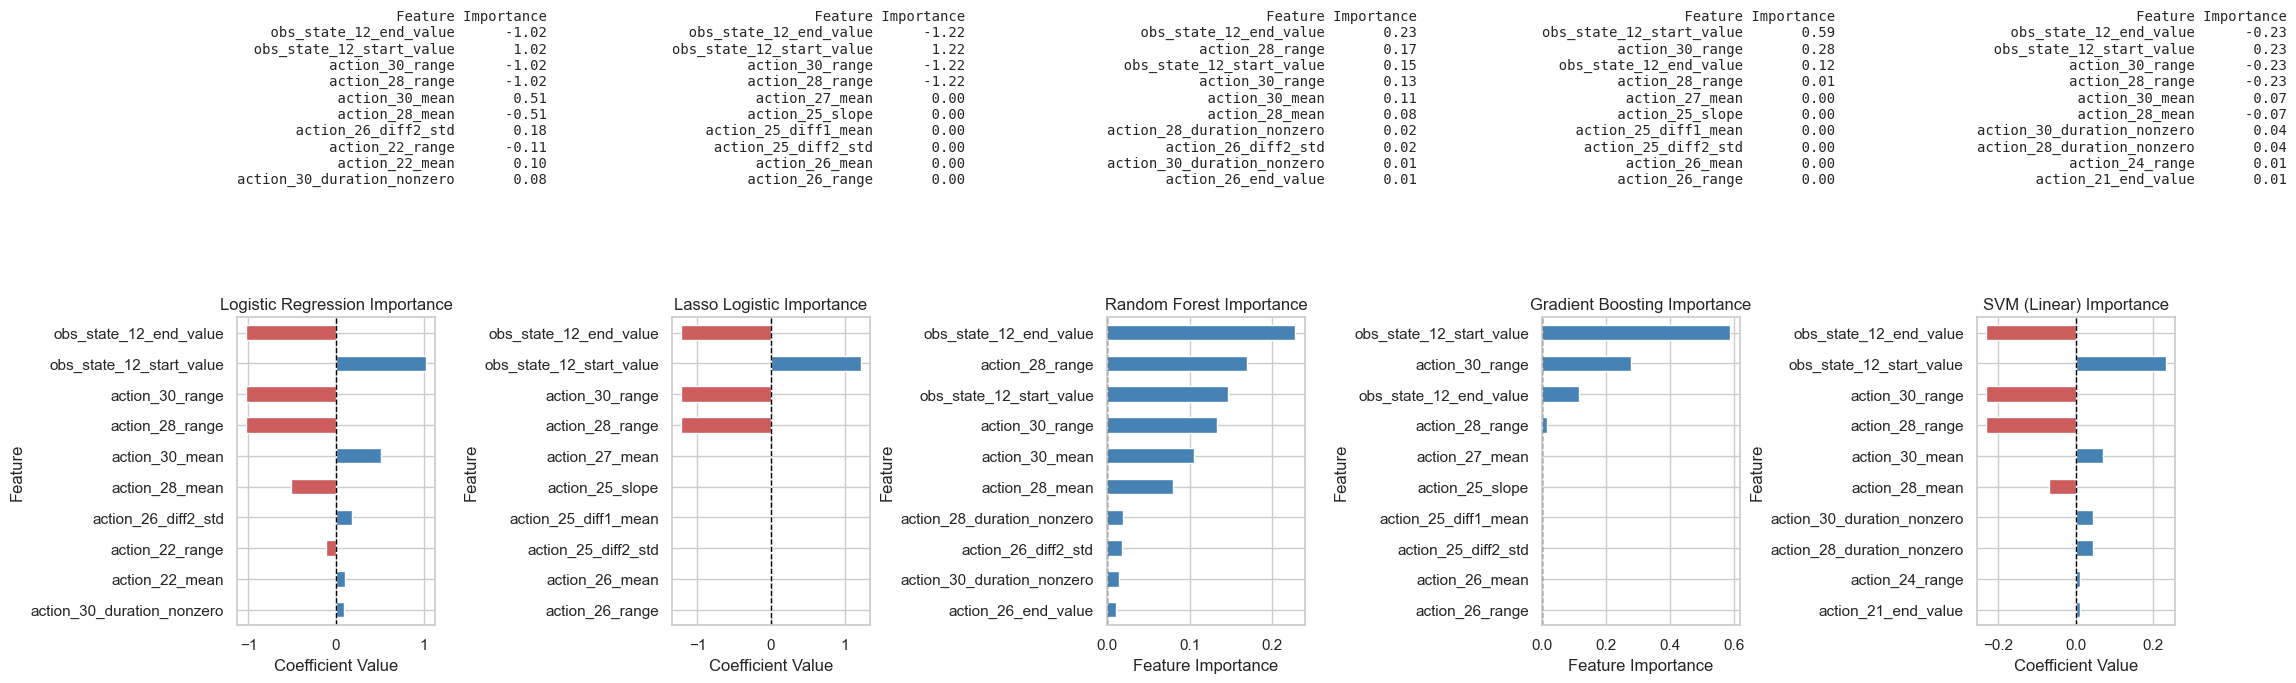

['trained_models/feature_columns.pkl']

In [ ]:
#----------------------------------------------
# Feature Importance Analysis with Multiple Models
#----------------------------------------------
# This script trains multiple models on the standardized features, evaluates their performance using cross-validation, and visualizes feature importances. It saves the trained models and selected features for future use.

import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import os

def plot_model_feature_importances_raw(X_dict, y, top_k=20):
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear', multi_class='ovr'),
        "Lasso Logistic": LogisticRegression(penalty='l1', C=1.0, solver='saga', max_iter=1000, multi_class='ovr'),
        "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=10,
                                                min_samples_leaf=5, max_features='sqrt', criterion='gini',
                                                oob_score=True, random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(n_estimators=50, max_depth=2,
                                                         random_state=42, min_samples_split=10, learning_rate=0.1),
        "SVM (Linear)": LinearSVC(max_iter=1000)
    }

    os.makedirs("trained_models", exist_ok=True)

    importance_tables = {}
    importance_bars = {}
    summary_table = []  # Store summary information for all models

    for name, model in models.items():
        X_model = X_dict[name]

        scores = cross_val_score(model, X_model, y, cv=5, scoring='accuracy')
        cv_mean = scores.mean()
        cv_std = scores.std()
        print(f"{name:<20} CV Accuracy: {cv_mean:.3f} ± {cv_std:.3f}")

        model.fit(X_model, y)
        joblib.dump(model, f"trained_models/{name.lower().replace(' ', '_')}.pkl")

        if name in ["Logistic Regression", "Lasso Logistic", "SVM (Linear)"]:
            coefs = model.coef_[0]
        elif name in ["Random Forest", "Gradient Boosting"]:
            coefs = model.feature_importances_
        else:
            raise ValueError(f"Unsupported model: {name}")

        importance = pd.DataFrame({
            'Feature': X_model.columns,
            'Importance': coefs.round(4)
        }).sort_values(by='Importance', key=lambda x: np.abs(x), ascending=False).reset_index(drop=True)

        nonzero_count = np.sum(importance['Importance'] != 0)
        print(f"{name:<20} Selected Non-zero Features: {nonzero_count}")

        # Summary table for all models
        summary_table.append({
            "Model": name,
            "CV Accuracy": f"{cv_mean:.3f} ± {cv_std:.3f}",
            "Selected Non-zero Features": nonzero_count
        })

        importance_tables[name] = importance
        importance_bars[name] = importance.set_index('Feature')['Importance']

        top_features = importance.head(top_k)['Feature'].tolist()
        joblib.dump(top_features, f"trained_models/selected_features_{name.lower().replace(' ', '_')}.pkl")

    # Create summary DataFrame
    summary_df = pd.DataFrame(summary_table)
    print("\nModel Summary Table:")
    print(summary_df.to_string(index=False))

    # Save summary table to CSV
    summary_df.to_csv("trained_models/model_summary.csv", index=False)

    # Visualize feature importances
    fig, axes = plt.subplots(2, 5, figsize=(25, 8), gridspec_kw={'hspace': 0, 'wspace': 1.2})

    for i, (name, table) in enumerate(importance_tables.items()):
        ax = axes[0, i]
        ax.axis('off')
        table_text = table.head(10).to_string(index=False, formatters={'Importance': '{:.2f}'.format})
        ax.text(0, 1, table_text, fontsize=10, family='monospace',
                verticalalignment='top', horizontalalignment='left')

        ax = axes[1, i]
        bar_data = importance_bars[name].head(10)
        colors = ['steelblue' if val > 0 else 'indianred' for val in bar_data]
        bar_data.plot(kind='barh', ax=ax, color=colors)
        ax.axvline(0, color='black', linestyle='--', linewidth=1)
        ax.set_title(f"{name} Importance")
        if name in ["Logistic Regression", "Lasso Logistic", "SVM (Linear)"]:
           ax.set_xlabel("Coefficient Value")
        elif name in ["Random Forest", "Gradient Boosting"]:
           ax.set_xlabel("Feature Importance")
        ax.invert_yaxis()

    fig.tight_layout()
    plt.show()
    return importance_tables

# Example usage
X_logistic = X_train_scaled
X_lasso = X_train_scaled
X_rf = X_train_scaled
X_gbm = X_train_scaled
X_svm = X_train_scaled

X_dict = {
    "Logistic Regression": X_logistic,
    "Lasso Logistic": X_lasso,
    "Random Forest": X_rf,
    "Gradient Boosting": X_gbm,
    "SVM (Linear)": X_svm
}

importance_tables = plot_model_feature_importances_raw(X_dict, y_train)

# Save the selected top_k features and full feature columns for future use
import joblib
joblib.dump(X_train_scaled.columns.tolist(), "trained_models/feature_columns.pkl")


#### Visualize Detailed Features Selected by Each Model

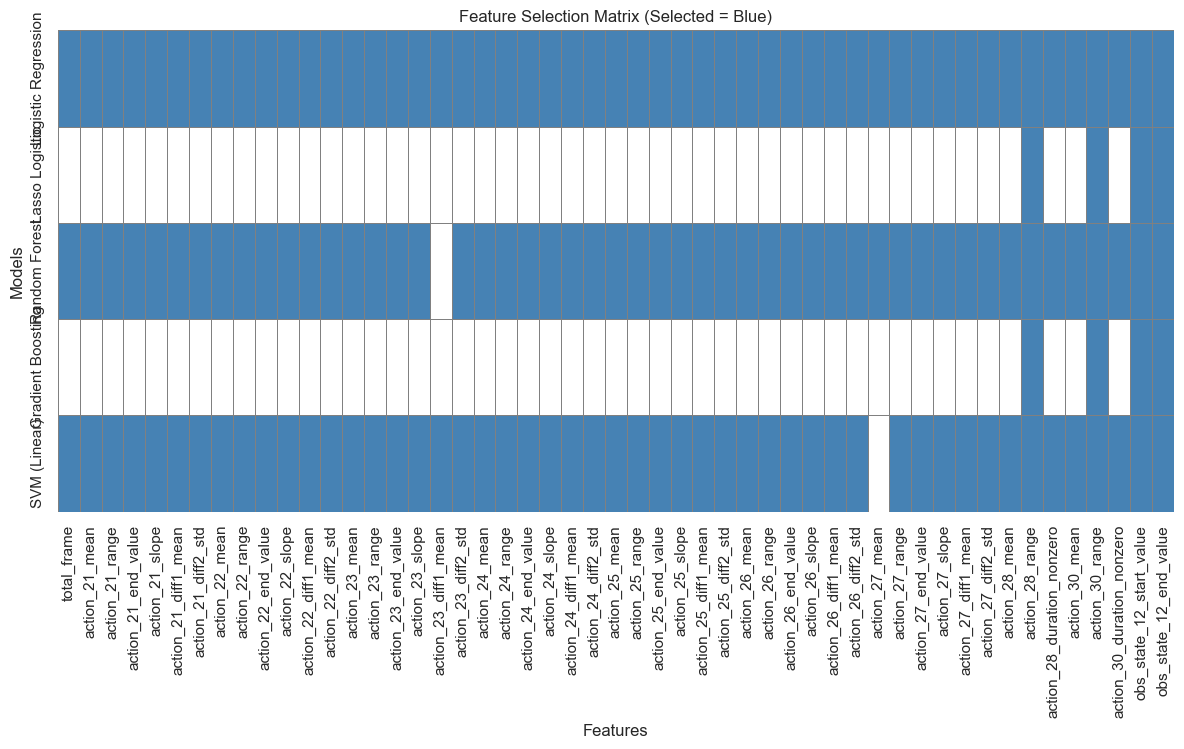

In [ ]:
#-----------------------------------
# Build Feature Selection Matrix
#-----------------------------------
# Visualize which features were selected by each model based on their importance scores.

# Step 1: Build feature selection matrix correctly
selection_matrix = pd.DataFrame(index=X_train_scaled.columns)

for model_name, importance_df in importance_tables.items():
    importance_df_aligned = importance_df.set_index("Feature").reindex(X_train_scaled.columns)
    selected = importance_df_aligned['Importance'].abs() > 1e-6
    selection_matrix[model_name] = selected.values

# Step 2: Save
selection_matrix.to_csv("trained_models/feature_selection_matrix.csv")

# Step 3: Visualize
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, len(selection_matrix) * 0.15))
sns.heatmap(selection_matrix.T, cmap=["white", "steelblue"], cbar=False, linewidths=0.5, linecolor='gray')
plt.title("Feature Selection Matrix (Selected = Blue)")
plt.xlabel("Features")
plt.ylabel("Models")
plt.tight_layout()
plt.show()


### Modoel Evaluation

#### Model Evaluation on Open/Close Drawer Task

Missing Value Report:
  All variables have 0 missing rate.


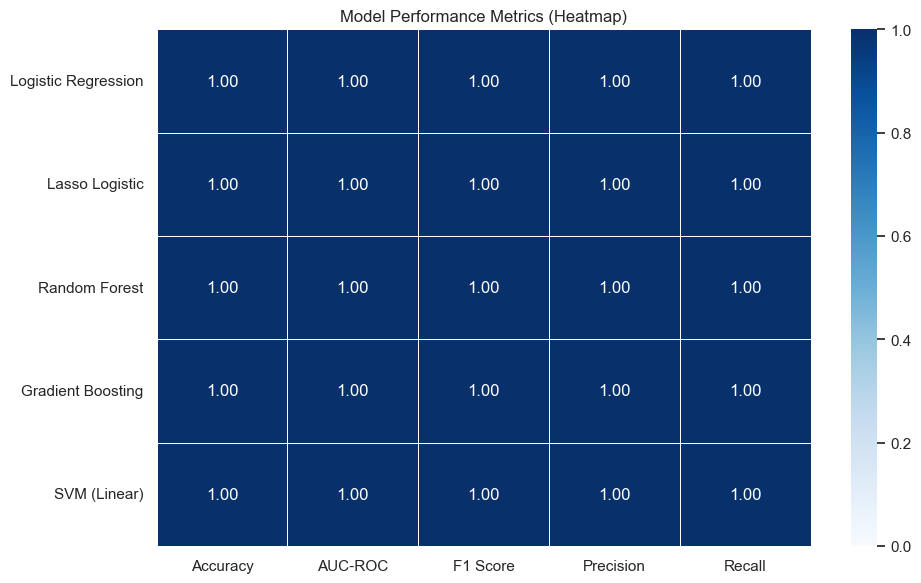

In [ ]:
#--------------------------------------------------------------------------
# Evaluate Models on Open/Close Drawer Test Set and Output Heatmap
#--------------------------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.exceptions import NotFittedError

# Step 1: Prepare test features aligned with training features
def prepare_test_features_aligned_with_train(
    test_df,
    compute_episode_level_features,
    process_and_standardize_features,
    trained_scaler,
    feature_columns
):
    """
    Process raw test data into aligned and standardized feature matrix.

    Parameters:
        test_df (DataFrame): raw test data
        compute_episode_level_features (function): user-defined feature extractor
        process_and_standardize_features (function): preprocessing function
        trained_scaler (StandardScaler): scaler fitted on training data
        feature_columns (list): columns used during training

    Returns:
        X_test_scaled_aligned (DataFrame): processed test features
        y_test (Series): true test labels
    """
    # Compute features at episode level
    test_episode_features_df = compute_episode_level_features(test_df)

    # Extract label and features
    y_test = test_episode_features_df["label_index"]
    X_test_all = test_episode_features_df.drop(columns=["label_index", "episode_index"])

    # Keep only training feature columns
    X_test_selected = X_test_all[[col for col in feature_columns if col in X_test_all.columns]]

    # Preprocess test features (winsorize + standardize)
    X_test_scaled, _ = process_and_standardize_features(X_test_selected, scaler=trained_scaler)

    # Reorder columns to match training order
    X_test_scaled_aligned = X_test_scaled.reindex(columns=feature_columns, fill_value=0)

    return X_test_scaled_aligned, y_test

# Step 2: Evaluate all models on the test set
def evaluate_all_models_heatmap(test_inputs, y_test, trained_models, save_csv=False):
    """
    Evaluate trained classification models on the test set using various performance metrics.

    Parameters:
        test_inputs (DataFrame): Feature matrix for the test set
        y_test (Series): Ground truth labels for the test set
        trained_models (dict): Dictionary of trained model objects
        save_csv (bool): Whether to save the results as a CSV file

    Returns:
        results_df (DataFrame): A DataFrame containing evaluation metrics for each model
    """

    # Initialize a dictionary to store performance metrics
    metrics = {
        "Accuracy": [],
        "AUC-ROC": [],
        "F1 Score": [],
        "Precision": [],
        "Recall": []
    }
    model_names = []

    for name, model in trained_models.items():
        try:
            y_pred = model.predict(test_inputs)

            # Get prediction scores for ROC-AUC if available
            if hasattr(model, "predict_proba"):
                y_score = model.predict_proba(test_inputs)[:, 1]
            elif hasattr(model, "decision_function"):
                y_score = model.decision_function(test_inputs)
            else:
                y_score = None

            # Calculate evaluation metrics
            acc = accuracy_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_score) if y_score is not None else np.nan
            f1 = f1_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)

            # Append results to each metric
            metrics["Accuracy"].append(acc)
            metrics["AUC-ROC"].append(auc)
            metrics["F1 Score"].append(f1)
            metrics["Precision"].append(prec)
            metrics["Recall"].append(recall)
            model_names.append(name)

        except NotFittedError:
            print(f"{name} is not fitted.")
        except Exception as e:
            print(f"{name} failed with error: {e}")

    # Create a DataFrame from the metric results
    results_df = pd.DataFrame(metrics, index=model_names)

    # Draw heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(results_df, annot=True, fmt=".2f", cmap="Blues", linewidths=0.5, vmin=0, vmax=1)
    plt.title("Model Performance Metrics (Heatmap)")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Optionally save results
    if save_csv:
        results_df.to_csv("model_test_metrics.csv")

    return results_df

# Step 3: Load trained models and pre-saved training artifacts
trained_models = {
    "Logistic Regression": joblib.load("trained_models/logistic_regression.pkl"),
    "Lasso Logistic": joblib.load("trained_models/lasso_logistic.pkl"),
    "Random Forest": joblib.load("trained_models/random_forest.pkl"),
    "Gradient Boosting": joblib.load("trained_models/gradient_boosting.pkl"),
    "SVM (Linear)": joblib.load("trained_models/svm_(linear).pkl")
}

feature_columns = joblib.load("trained_models/feature_columns.pkl")
train_scaler = joblib.load("trained_models/train_scaler.pkl")

# Step 4: Prepare test data (provide your own test_df and compute_episode_level_features)
X_test_selected, y_test = prepare_test_features_aligned_with_train(
    test_df,
    compute_episode_level_features,
    process_and_standardize_features,
    trained_scaler=train_scaler,
    feature_columns=feature_columns
)

# Step 5: Evaluate and output heatmap only
results_df = evaluate_all_models_heatmap(
    X_test_selected,
    y_test,
    trained_models,
    save_csv=True 
)

####  Cross-Task Generalization Test

In [ ]:
#-------------------------------------
# Looad the other task dataset from Hugging Face and process it similarly to the open-close drawer dataset.
# This dataset contains action and observation vectors, which we will parse and expand into a structured DataFrame.
#-------------------------------------

import pandas as pd
import numpy as np
import ast

def load_and_parse_robot_dataset(csv_url, expected_action_dim=34, expected_obs_dim=13):
    """
    Load a robotics dataset from Hugging Face CSV, parse vector strings,
    expand arrays into columns, and return a structured DataFrame.

    Parameters:
        csv_url (str): Raw .csv file URL (must be /resolve/ path)
        expected_action_dim (int): Expected dimension of action vectors
        expected_obs_dim (int): Expected dimension of observation vectors

    Returns:
        pd.DataFrame: Cleaned and structured DataFrame
    """

    # Step 1: Load the CSV file
    df = pd.read_csv(csv_url)

    # Step 2: Parse vector string using ast.literal_eval (safe for '[1.0, 2.0]' format)
    def parse_vector_string(s):
        try:
            lst = ast.literal_eval(s)
            return np.array(lst, dtype=float)
        except:
            return np.nan

    df['action_vec'] = df['action'].apply(parse_vector_string)
    df['obs_state_vec'] = df['observation.state'].apply(parse_vector_string)

    # Step 3: Filter rows with correct vector dimensions
    valid_action = df['action_vec'].apply(lambda x: isinstance(x, np.ndarray) and len(x) == expected_action_dim)
    valid_obs = df['obs_state_vec'].apply(lambda x: isinstance(x, np.ndarray) and len(x) == expected_obs_dim)
    df_valid = df[valid_action & valid_obs].copy()

    # Step 4: Expand into individual columns
    action_cols = [f'action_{i}' for i in range(expected_action_dim)]
    obs_cols = [f'obs_state_{i}' for i in range(expected_obs_dim)]

    action_df = pd.DataFrame(df_valid['action_vec'].tolist(), columns=action_cols)
    obs_df = pd.DataFrame(df_valid['obs_state_vec'].tolist(), columns=obs_cols)

    # Step 5: Merge back into final DataFrame
    df_final_other_task = pd.concat([df_valid.reset_index(drop=True), action_df, obs_df], axis=1)

    # Optional: Improve display in notebook
    pd.set_option("display.precision", 20)
    pd.set_option("display.max_columns", None)
    pd.set_option("display.max_colwidth", None)

    return df_final_other_task


csv_url = "https://huggingface.co/datasets/caiyan123/merged_other_task/resolve/main/merged_other_task.csv"
df_final_other_task = load_and_parse_robot_dataset(csv_url)
print(df_final_other_task.shape)
df_final_other_task.head(3)




(24509, 58)


,action,observation.state,timestamp,frame_index,episode_index,index,task_index,label_index,task,action_vec,obs_state_vec,action_0,action_1,action_2,action_3,action_4,action_5,action_6,action_7,action_8,action_9,action_10,action_11,action_12,action_13,action_14,action_15,action_16,action_17,action_18,action_19,action_20,action_21,action_22,action_23,action_24,action_25,action_26,action_27,action_28,action_29,action_30,action_31,action_32,action_33,obs_state_0,obs_state_1,obs_state_2,obs_state_3,obs_state_4,obs_state_5,obs_state_6,obs_state_7,obs_state_8,obs_state_9,obs_state_10,obs_state_11,obs_state_12
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.4997134804725647, -0.025464791804552078, 0.011566286906599998, -0.7853981852531433, -1.5707963705062866, 1.0471975803375244, 1.5707963705062866, 0.0, 1.0471975803375244, -2.481858253479004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -2.356194496154785, 1.5707963705062866, -1.0471975803375244, -1.5707963705062866, -0.0, -1.0471975803375244, 2.481858253479004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 3.2264645099639893, 0.0, 1.0, 0.0, -0.04783296212553978, 0.0, 0.0, 1.0, 0.0, 0.0]",0.00000000000000000000,0,82,39841,82,0,open_fridge,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.4997134804725647, -0.025464791804552078, 0.011566286906599998, -0.7853981852531433, -1.5707963705062866, 1.0471975803375244, 1.5707963705062866, 0.0, 1.0471975803375244, -2.481858253479004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -2.356194496154785, 1.5707963705062866, -1.0471975803375244, -1.5707963705062866, -0.0, -1.0471975803375244, 2.481858253479004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 3.2264645099639893, 0.0, 1.0, 0.0, -0.04783296212553978, 0.0, 0.0, 1.0, 0.0, 0.0]",0.0,0.0,0.0,0.0,0.0,0.49971348047256469727,-0.02546479180455207825,0.01156628690659999847,-0.78539818525314331055,-1.57079637050628662109,1.04719758033752441406,1.57079637050628662109,0.0,1.04719758033752441406,-2.48185825347900390625,0.0,0.0,0.0,0.0,0.0,0.0,-2.35619449615478515625,1.57079637050628662109,-1.04719758033752441406,-1.57079637050628662109,-0.0,-1.04719758033752441406,2.48185825347900390625,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.22646450996398925781,0.0,1.0,0.0,-0.04783296212553977966,0.0,0.0,1.0,0.0,0.0
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.4997134804725647, -0.055704228579998016, 0.0253012515604496, -0.7853981852531433, -1.5707963705062866, 1.0471975803375244, 1.5707963705062866, 0.0, 1.0471975803375244, -2.481858253479004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -2.356194496154785, 1.5707963705062866, -1.0471975803375244, -1.5707963705062866, 0.0, -1.0471975803375244, 2.481858253479004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 3.2264645099639893, 0.0, 1.0, 0.0, -0.04783296212553978, 0.0, 0.0, 1.0, 0.0, 0.0]",0.02000000000000000042,1,82,39842,82,0,open_fridge,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.4997134804725647, -0.055704228579998016, 0.0253012515604496, -0.7853981852531433, -1.5707963705062866, 1.0471975803375244, 1.5707963705062866, 0.0, 1.0471975803375244, -2.481858253479004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -2.356194496154785, 1.5707963705062866, -1.0471975803375244, -1.5707963705062866, 0.0, -1.0471975803375244, 2.481858253479004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 3.2264645099639893, 0.0, 1.0, 0.0, -0.04783296212553978, 0.0, 0.0, 1.0, 0.0, 0.0]",0.0,0.0,0.0,0.0,0.0,0.49971348047256469727,-0.05570422857999801636,0.02530125156044960022,-0.78539818525314331055,-1.57079637050628662109,1.04719758033752441406,1.57079637050628662109,0.0,1.04719758033752441406,-2.48185825347900390625,0.0,0.0,0.0,0.0,0.0,0.0,-2.35619449615478515625,1.57079637050628662109,-1.04719758033752441406,-1.57079637050628662109,0.0,-1.04719758033752441406,2.48185825347900390625,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.22646450996398925781,0.0,1.0,0.0,-0.04783296212553977966,0.0,0.0,1.0,0.0,0.0
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.4997134804725647, -0.08753521740436554, 0.039759110659360886, -0.7853981852531433, -1.5707963705062866, 1.0471975803375244, 1.5707963705062866, 0.0, 1.0471975803375244, -2.48185825347900

Missing Value Report:
Removed constant columns: []


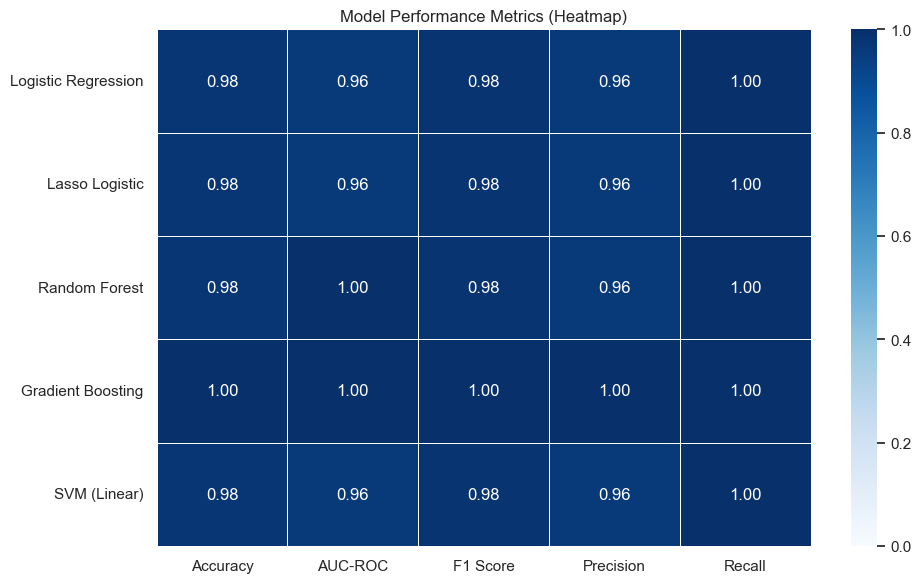

In [ ]:
#--------------------------------------------------------------------------
# Compute episode-level features for the other task dataset
# and evaluate all models trained on the open-close drawer dataset on this new dataset.
#--------------------------------------------------------------------------

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Step 1: Compute episode-level features grouped by task, label, and episode
def compute_episode_level_features_with_task(df):
    action_vars_21_27 = [f'action_{i}' for i in range(21, 28)]
    action_vars_28_30 = ['action_28', 'action_30']
    obs_vars = ['obs_state_12']
    all_vars = action_vars_21_27 + action_vars_28_30 + obs_vars

    episode_features = []
    missing_rate_dict = {var: [] for var in all_vars}

    for (task, label_index, episode_index), group in df.groupby(['task', 'label_index', 'episode_index']):
        episode_data = {
            'task': task,
            'label_index': label_index,
            'episode_index': episode_index,
            'total_frame': len(group)
        }

        for var in all_vars:
            values = group[var].values
            missing_ratio = np.isnan(values).sum() / len(values)
            missing_rate_dict[var].append(missing_ratio)

            if var in action_vars_21_27:
                episode_data[f'{var}_mean'] = np.nanmean(values)
                episode_data[f'{var}_range'] = np.nanmax(values) - np.nanmin(values)
                episode_data[f'{var}_end_value'] = values[-1] if len(values) > 0 else np.nan
                episode_data[f'{var}_slope'] = (values[-1] - values[0]) / len(values) if len(values) > 1 else 0
                episode_data[f'{var}_diff1_mean'] = np.nanmean(np.diff(values)) if len(values) > 1 else np.nan
                episode_data[f'{var}_diff2_std'] = np.nanstd(np.diff(values, n=2)) if len(values) > 2 else np.nan

            elif var in action_vars_28_30:
                episode_data[f'{var}_mean'] = np.nanmean(values)
                episode_data[f'{var}_range'] = np.nanmax(values) - np.nanmin(values)
                episode_data[f'{var}_duration_nonzero'] = np.sum(values != 0) / len(values) if len(values) > 0 else np.nan

            elif var == 'obs_state_12':
                episode_data[f'{var}_start_value'] = values[0] if len(values) > 0 else np.nan
                episode_data[f'{var}_end_value'] = values[-1] if len(values) > 0 else np.nan

        episode_features.append(episode_data)

    episode_stats_df = pd.DataFrame(episode_features)

    print("Missing Value Report:")
    for var, rates in missing_rate_dict.items():
        avg_missing = np.mean(rates)
        if avg_missing > 0:
            print(f"  {var}: missing rate = {avg_missing:.2%}")

    return episode_stats_df

# Step 2: Preprocess the features (remove constant variables + standardize)
def preprocess_episode_features(episode_stats_df, trained_scaler=None):
    id_cols = episode_stats_df[["task", "episode_index", "label_index"]].reset_index(drop=True)
    feature_cols = episode_stats_df.drop(columns=["task", "episode_index", "label_index"])

    constant_cols = [col for col in feature_cols.columns if feature_cols[col].nunique() <= 1]
    print(f"Removed constant columns: {constant_cols}")
    feature_cols_cleaned = feature_cols.drop(columns=constant_cols)

    scaler = trained_scaler or StandardScaler()
    feature_scaled = pd.DataFrame(scaler.fit_transform(feature_cols_cleaned), columns=feature_cols_cleaned.columns)

    final_df = pd.concat([id_cols, feature_scaled], axis=1)
    return final_df, scaler

# Step 3: Compute episode-level features and preprocess
episode_feature_other_task_df = compute_episode_level_features_with_task(df_final_other_task)
final_other_task_df, other_task_scaler = preprocess_episode_features(episode_feature_other_task_df)

# Step 4: Save the scaler and feature columns for future use
y_test_other_task = final_other_task_df["label_index"]
X_test_selected_other_task = final_other_task_df.drop(columns=["label_index", "episode_index", "task"])

# Align test features with training feature columns
X_test_scaled_aligned_other_task = X_test_selected_other_task.reindex(columns=feature_columns, fill_value=0)

# Step 5: Evaluate all models on the other task test set
results_other_task_df = evaluate_all_models_heatmap(
    X_test_scaled_aligned_other_task,
    y_test_other_task,
    trained_models,
    save_csv=True
)